### Seasonality

- 시간이나 달력에 따라 주기적으로 변동하는 현상
    <br> 일일, 주간, 연간 단위로 반복되는 패턴

In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats("retina") # svg, retina, png2x ...
mpl.style.use("seaborn-v0_8")
mpl.rcParams.update({"figure.constrained_layout.use": True})
sns.set_context("paper") 
sns.set_palette("Set2") 
sns.set_style("whitegrid") 

plt.rc("font", family = "NanumSquareRound")
plt.rcParams["axes.unicode_minus"] = False

In [29]:
import yfinance as yf
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.linear_model import LinearRegression
from scipy import signal
from statsmodels.tsa.seasonal import seasonal_decompose

In [30]:
data = yf.download('spy', start='1900-04-01', end='2021-04-01')
data_ = data[["Close"]].copy()
data_.columns = [["Close"]]
data_.reset_index(inplace=True)
data_.columns = ["Date","Close"]
data_['Date'] = pd.to_datetime(data_['Date']) 

[*********************100%***********************]  1 of 1 completed


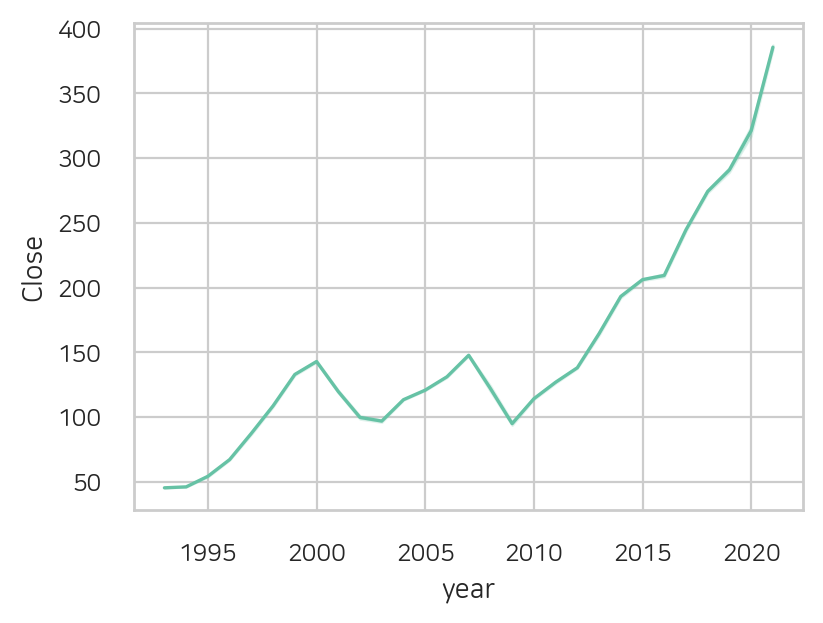

In [31]:
days_Y = pd.Series(data_["Date"].dt.day_of_year, name="day_of_year")
month = pd.Series(data_["Date"].dt.month, name="month")
week = pd.Series(data_["Date"].dt.day_name(), name="weeks")
diff_close = pd.Series(data_["Close"] - data_["Close"].shift(), name="diff_close")

df = pd.concat([data_,diff_close, days_Y,month,week],axis=1)
df["year"] = df["Date"].dt.year
df = df[["year","day_of_year","month","weeks","Close","diff_close"]]

fig, ax = plt.subplots(figsize = (4,3))
# 연도, 달, 주, 일별로 분류하고 마지막 가격으로 설정

sns.lineplot(data = df,
         x = "year",
         y = "Close",
         ax=ax);

### 계절성 확인

- 월별 변화 그래프

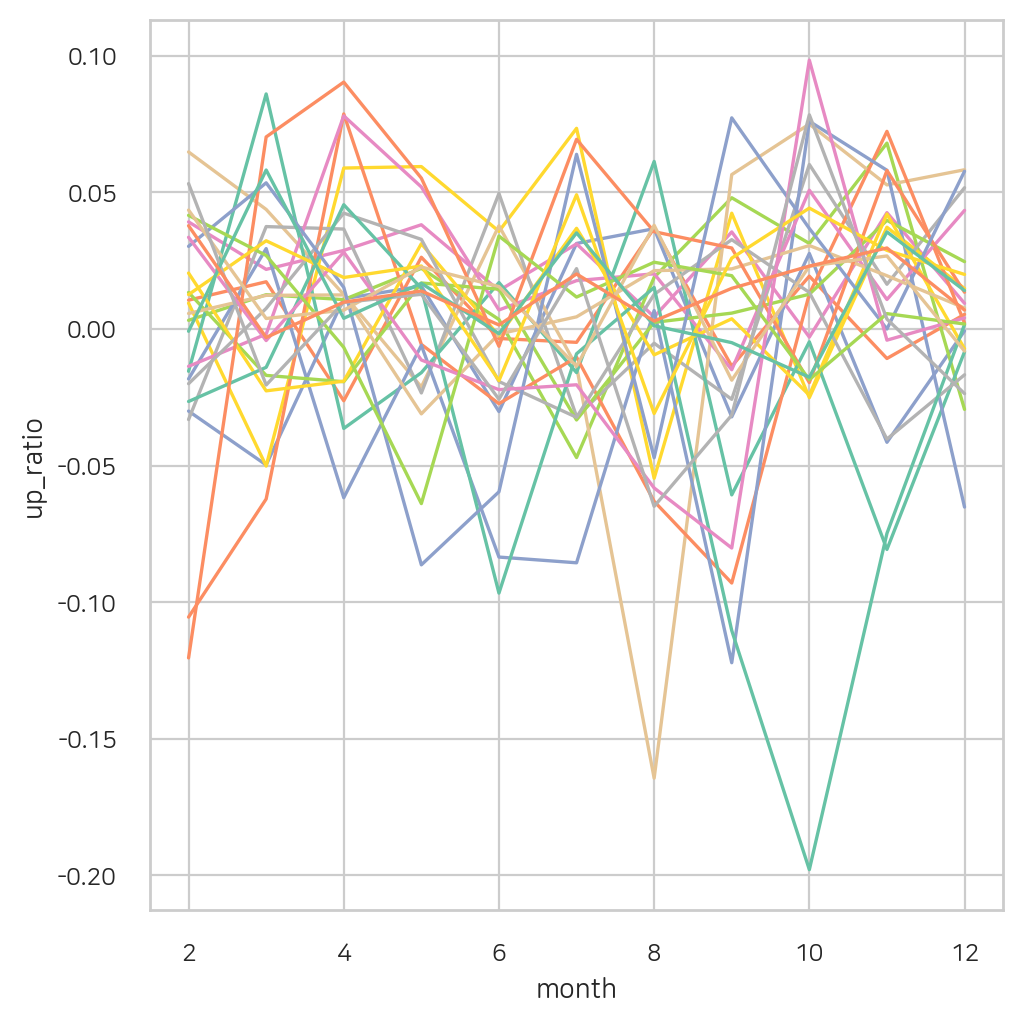

In [32]:
fig, ax = plt.subplots(figsize = (5,5))

for i in range(1928,2018):

    forgr_=df[df["year"]==i].groupby("month").last()
    forgr_["up_ratio"] = (forgr_["Close"] - forgr_["Close"].shift())/forgr_["Close"]
    sns.lineplot(data = forgr_,
             x = "month",
             y = "up_ratio",
             ax=ax);


- 주별 변화율 그래프

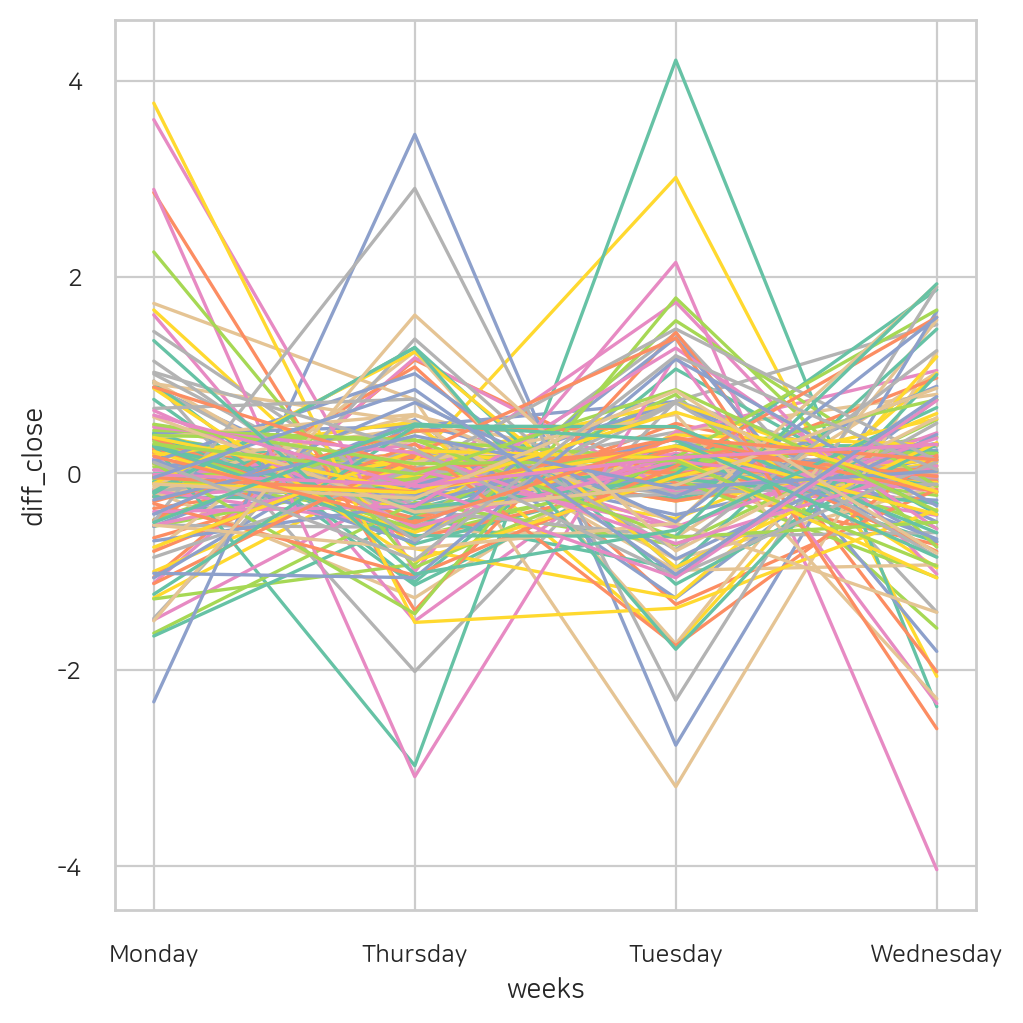

In [33]:
fig, ax = plt.subplots(figsize = (5,5))

for i in range(1928,2005):
    for month in range(1,13):
        y_m_w = df[(df["year"] == i) & (df["month"] == month)].groupby("weeks").mean()
        y_m_w = y_m_w - y_m_w.shift()
        sns.lineplot(data=y_m_w,
                     x = "weeks",
                     y = "diff_close",
                    ax=ax);

- 연도별 그래프

<Axes: xlabel='day_of_year', ylabel='Close'>

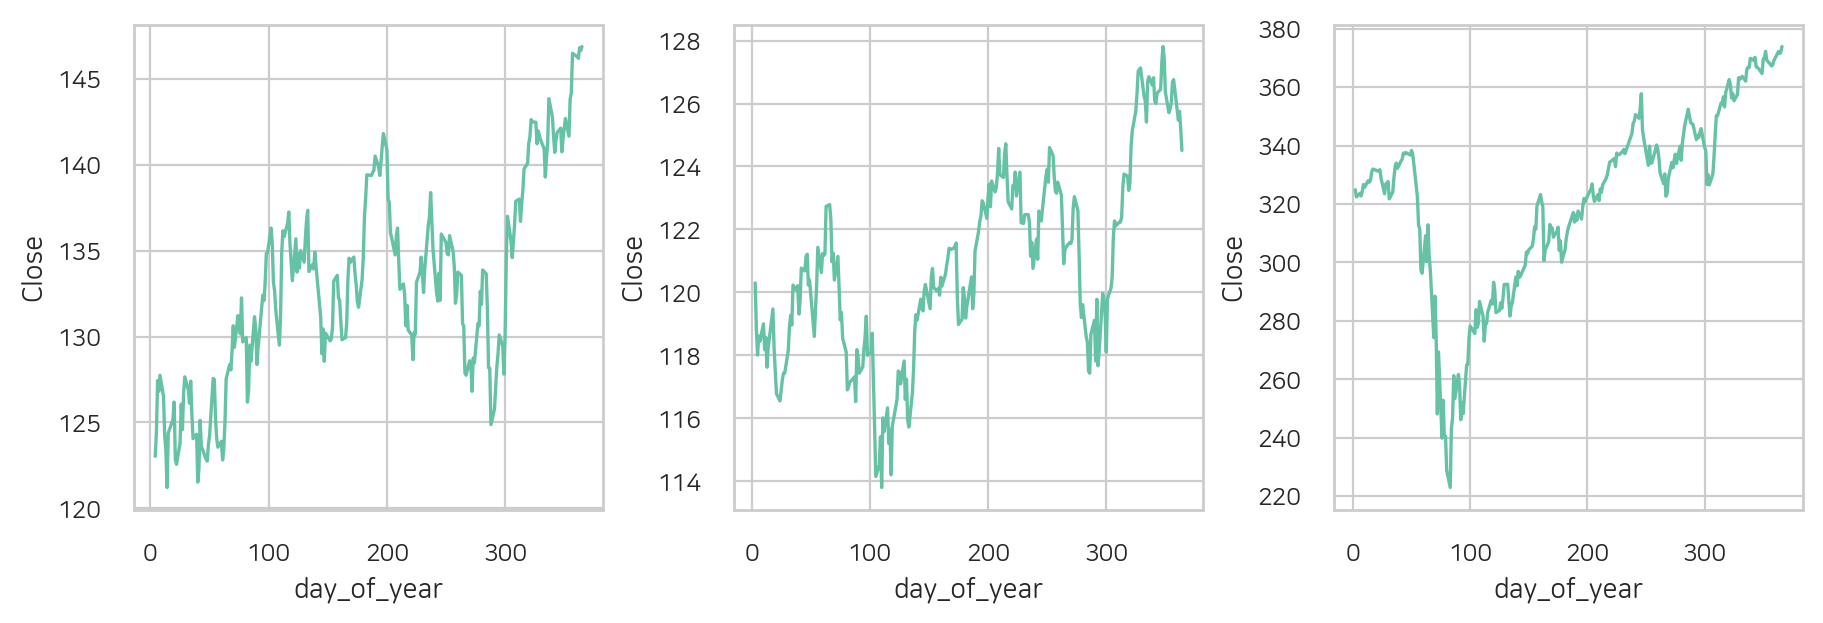

In [34]:
fig, ax = plt.subplots(1,3,figsize=(9,3))

sns.lineplot(data=df[df["year"] == 1999],
             x="day_of_year",
             y="Close",
             ax=ax[0])

sns.lineplot(data=df[df["year"] == 2005],
             x="day_of_year",
             y="Close",
             ax=ax[1])

sns.lineplot(data=df[df["year"] == 2020],
             x="day_of_year",
             y="Close",
             ax=ax[2])

- 연간 패턴 분석(주별 종가 기준)

<Axes: xlabel='day_of_year', ylabel='Close'>

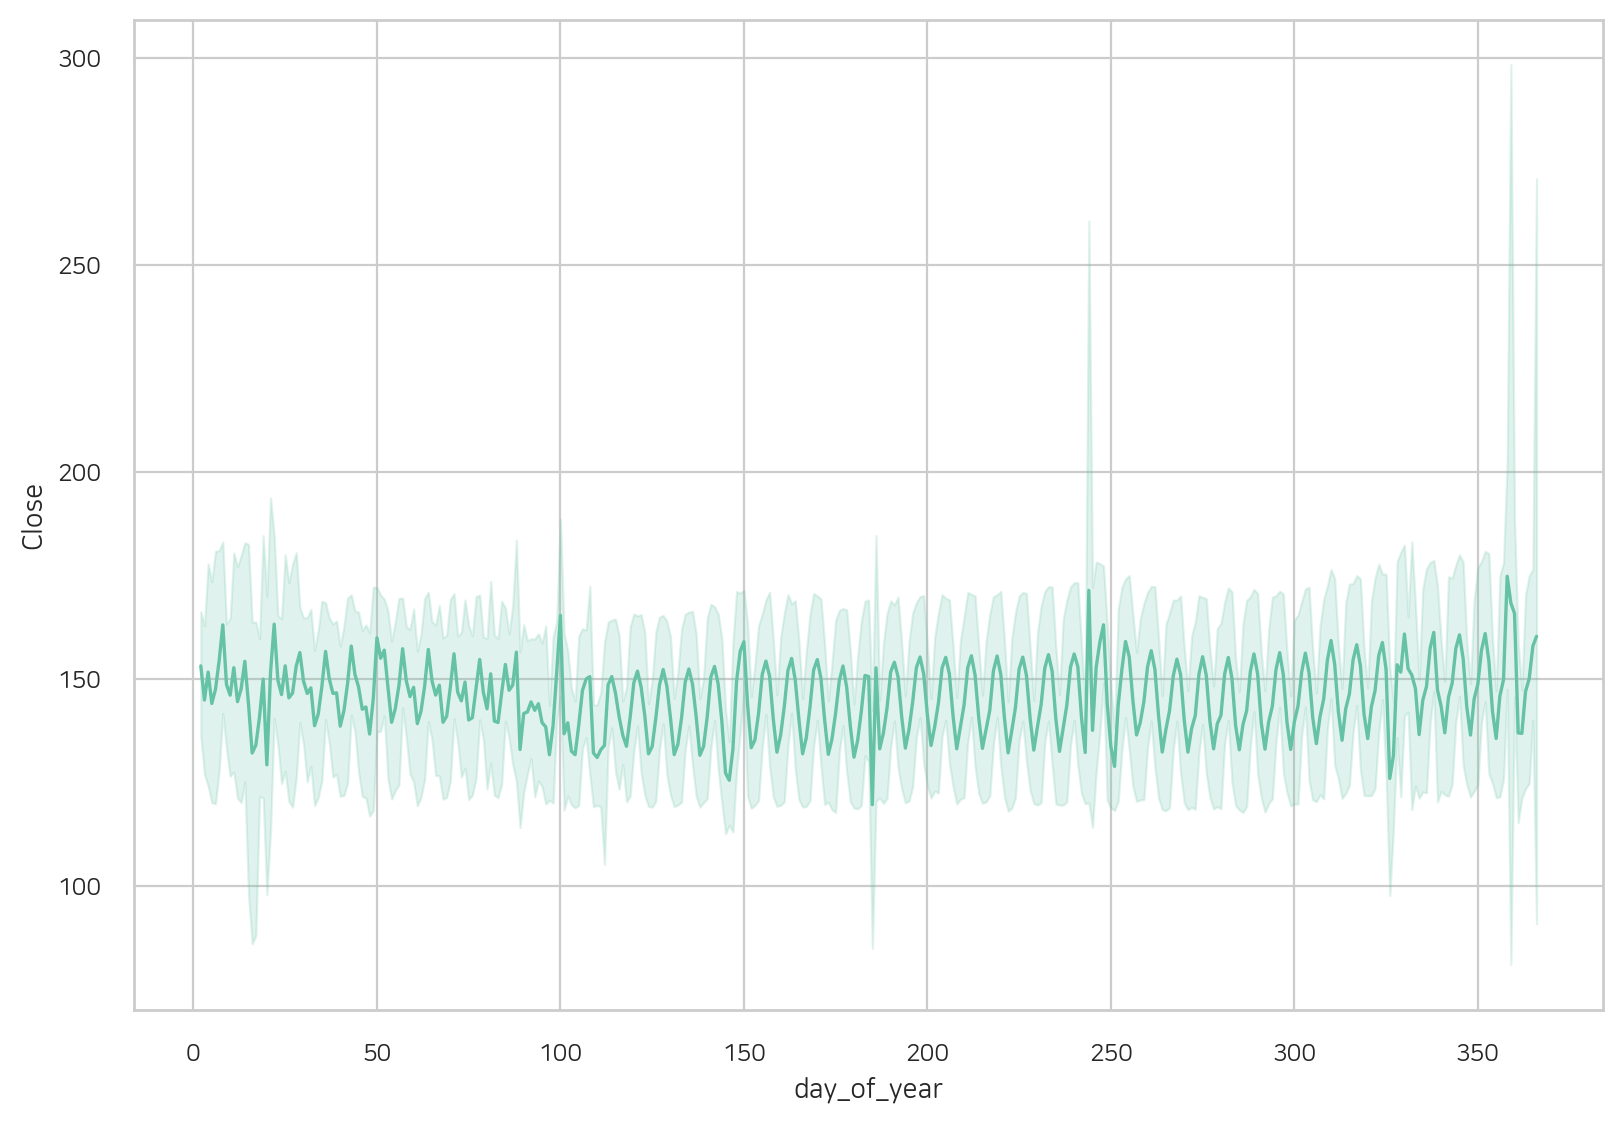

In [35]:
days_of_y = df.groupby(["day_of_year","weeks"]).mean()

fig, ax = plt.subplots()
sns.lineplot(data=days_of_y,
             x="day_of_year",
             y="Close",
             ax=ax)

- 특정 연도 기준 계절성 확인

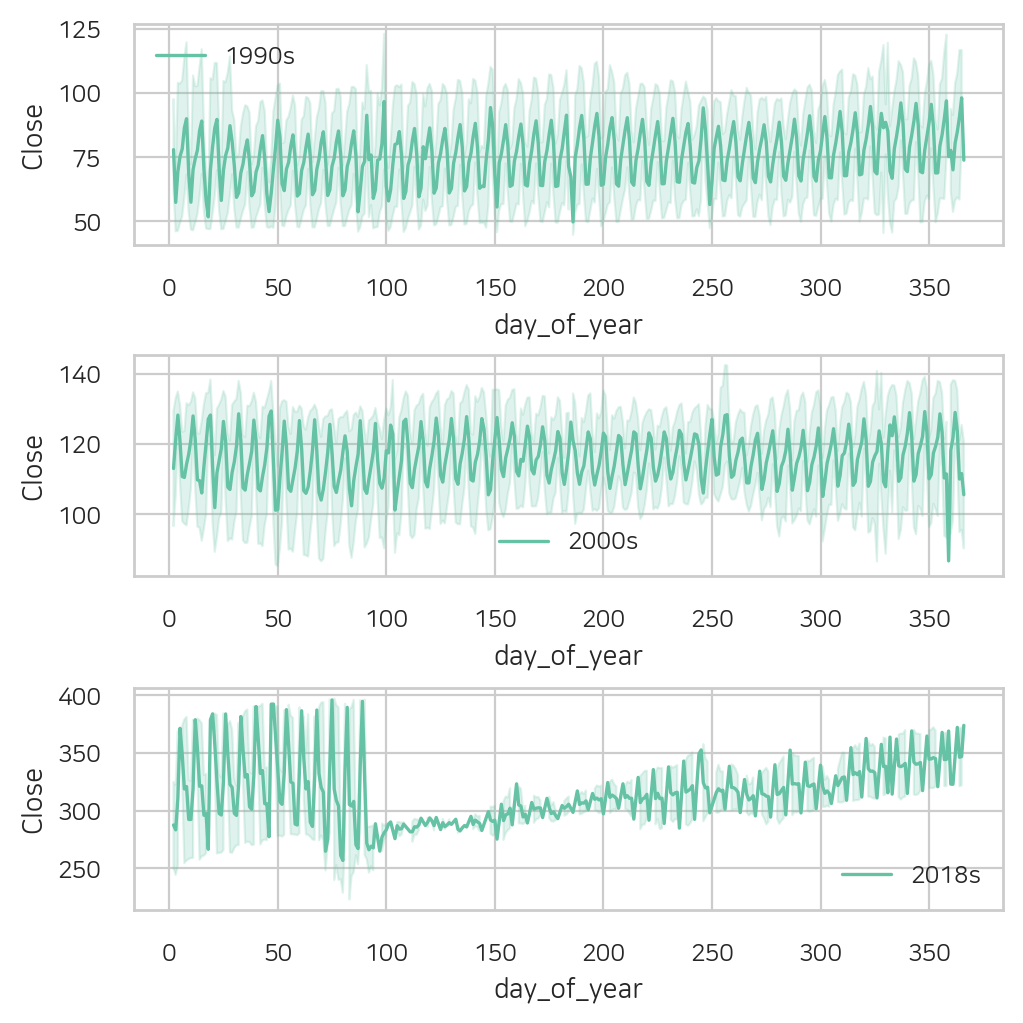

In [36]:
fig, ax = plt.subplots(3,1,figsize=(5,5))

for ax_,i in zip([0,1,2],[1990,2000,2018]):
    over = i < df["year"]
    under = df["year"] < i + 10

    period_df = df[over & under]
    days_of_y = period_df.groupby(["day_of_year","weeks"]).mean()

    sns.lineplot(data=days_of_y,
                 x="day_of_year",
                 y="Close",
                 label=str(i)+"s",
                 ax=ax[ax_])

### 주가 예측 모델 및 시각화

In [37]:
snp_500=data_.set_index("Date")
snp_500.index = snp_500.index.tz_localize(None)

- Fourier 변환(Fourier Transform)
  - 주어진 시계열 데이터를 주파수 성분으로 분해하는 수학적 도구.
  - 주파수 도메인에서 데이터의 패턴을 분석하는 데 유용.
  - 특히, 주기적인 신호를 간단한 사인파와 코사인파의 조합으로 표현할 수 있게해줌.
  - `freq`: 주기(daily, monthly, yearly 등) 설정
  - `order`: 사용될 사인/코사인 쌍의 개수, 이 숫자가 증가할수록 모델은 더 복잡해지며 데이터의 변동성을 더 잘 캡처할 수 있습니다.

- `DeterministicProcess`
  - 시계열 데이터에서 주기적 및 비주기적 요소를 모델링.
  - 하이퍼 파라미터
    - `index`: 시간 인덱스 (보통 날짜)입니다. 이 인덱스가 주어진 경우, 각 시점에 대해 특성을 자동으로 생성합니다.
    - `constant`: 상수항을 포함할지 여부를 설정합니다. 모델에 상수항을 포함하면 회귀 계수의 추정치를 조정하는 데 도움이 됩니다. (`True` 또는 `False`)
    - `order`: 데이터의 추세를 모델링할 다항식의 차수를 결정합니다. 예를 들어, 1은 선형 추세를, 2는 2차 추세를 나타냅니다.
    - `seasonal`: 계절성을 포함할지 여부를 설정합니다. `True`로 설정하면 계절 관련 메트릭도 포함됩니다.
    - `additional_terms`: Fourier 변환과 같은 추가적인 계절 성분을 포함하는 데 사용됩니다.
    - `drop`: 다중 공선성 문제를 피하기 위해 불필요한 항을 자동으로 제거합니다.

In [52]:
frequencies = ['YE', 'ME', 'W', 'D']

/home/tommy/miniconda3/envs/311/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:569: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  index = pd.date_range("2020-01-01", freq=freq, periods=1)
/home/tommy/miniconda3/envs/311/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:569: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  index = pd.date_range("2020-01-01", freq=freq, periods=1)
/home/tommy/miniconda3/envs/311/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:569: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  index = pd.date_range("2020-01-01", freq=freq, periods=1)
/home/tommy/miniconda3/envs/311/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:569: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  index = pd.date_range("202

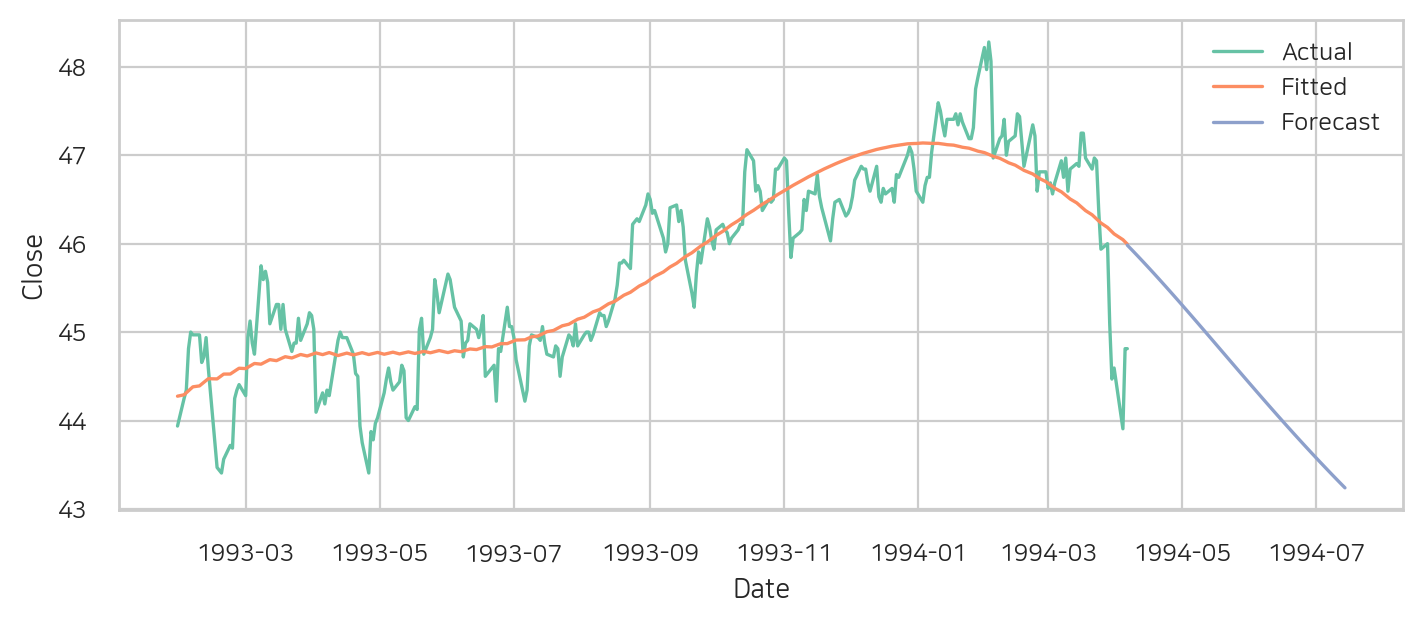

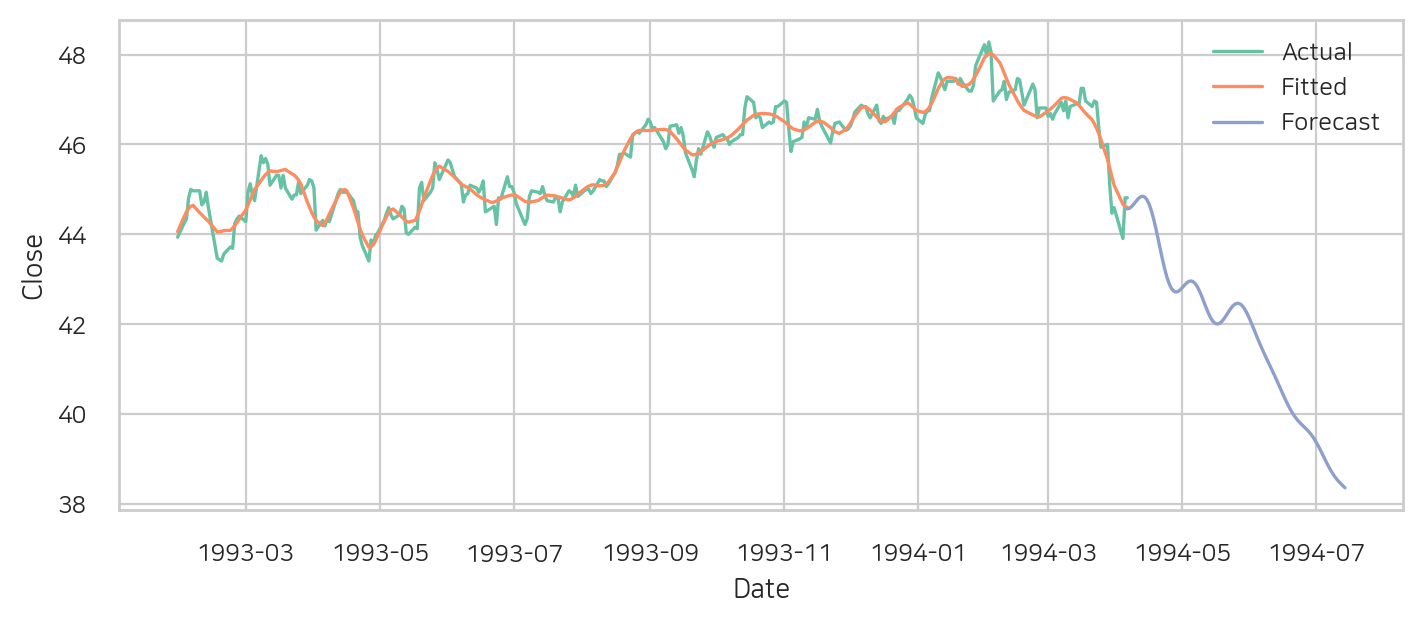

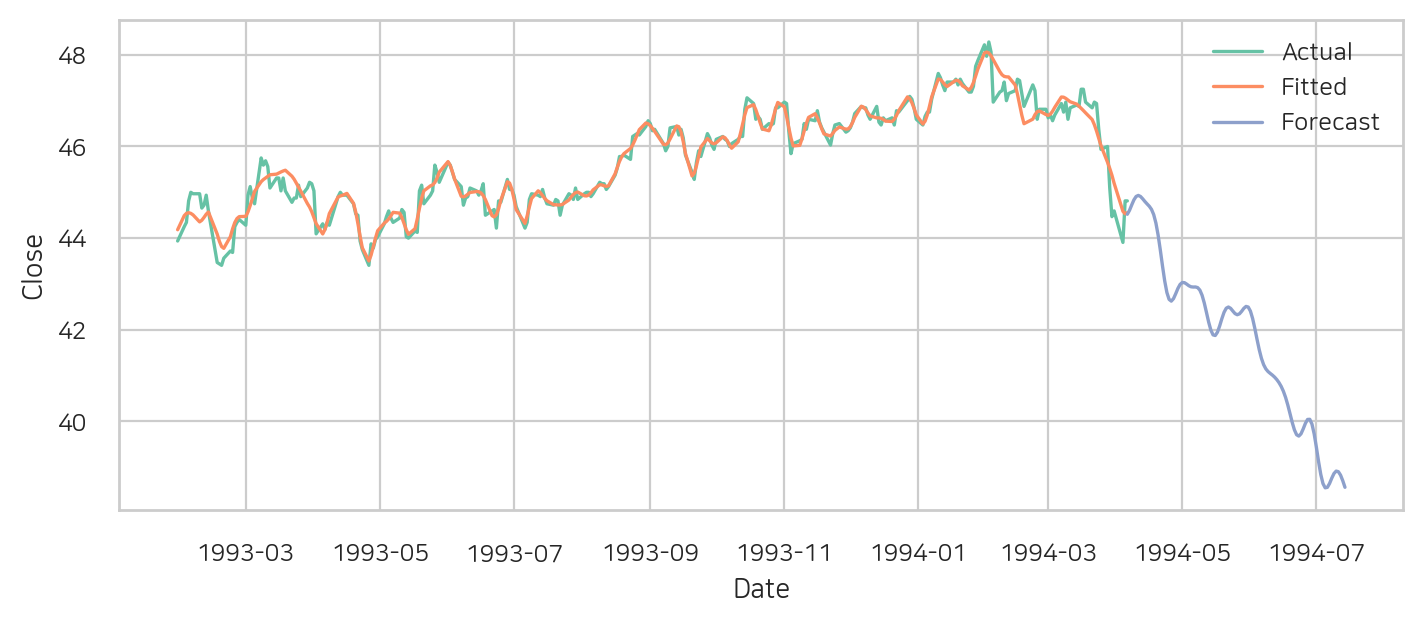

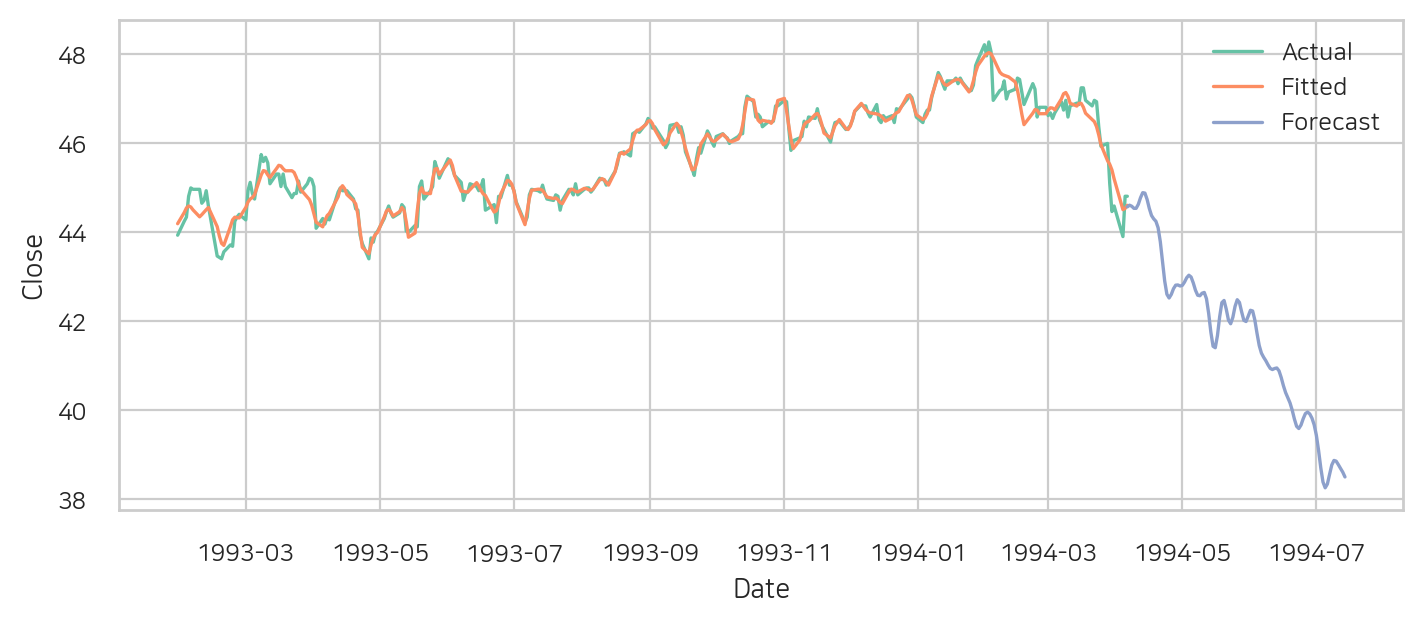

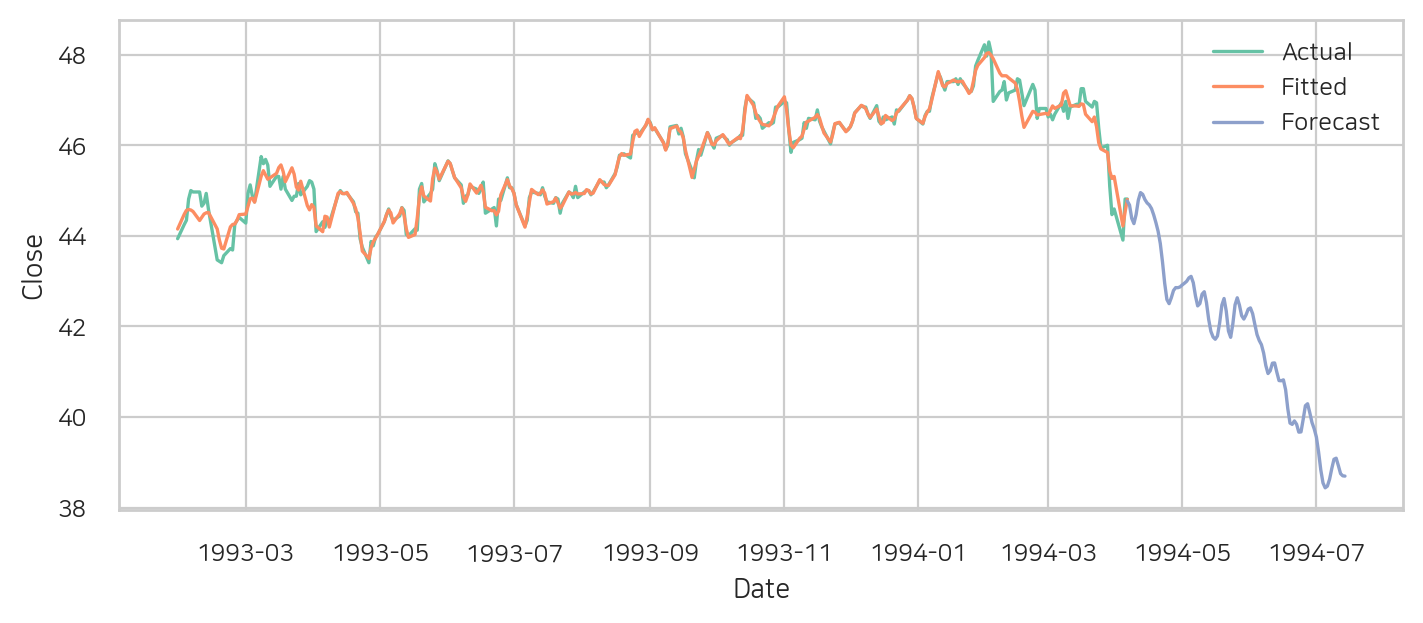

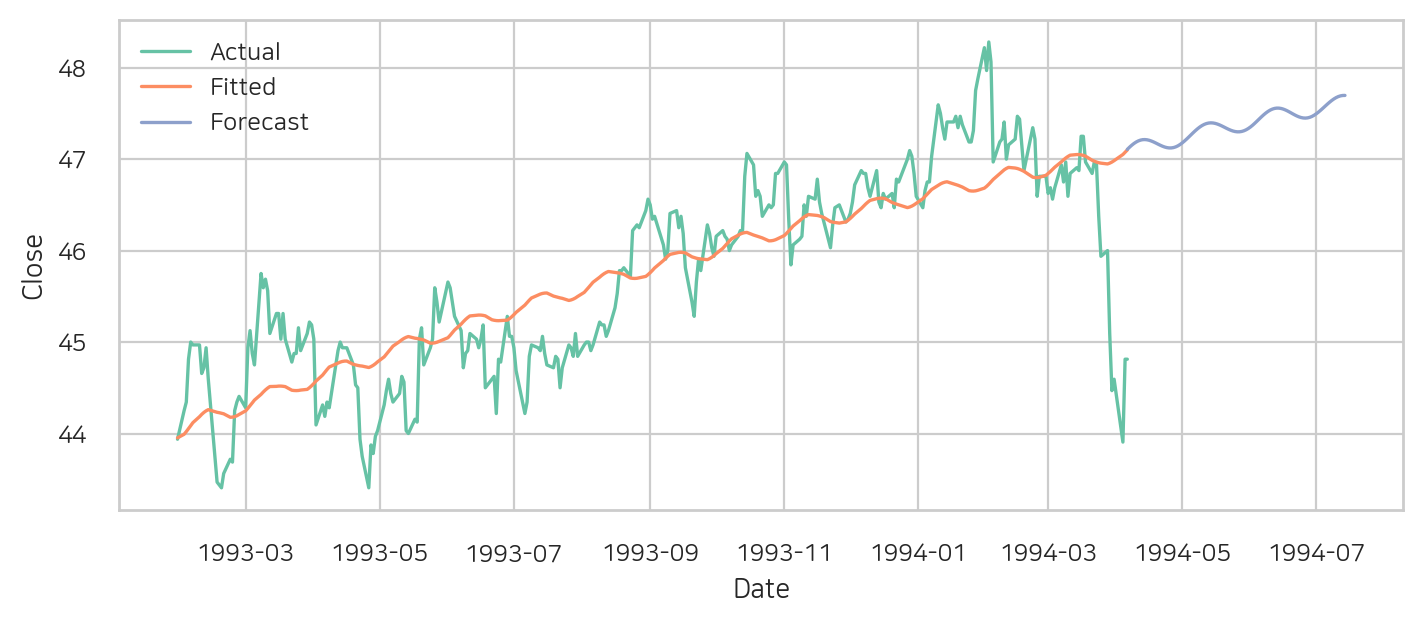

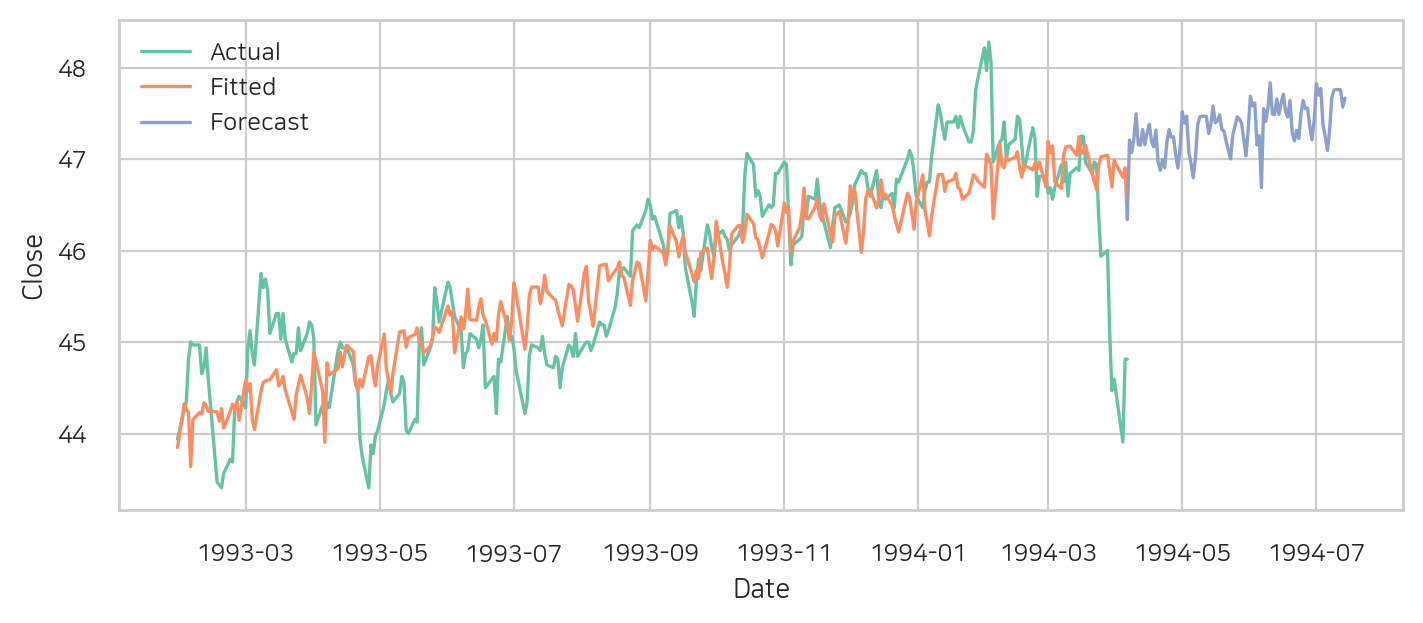

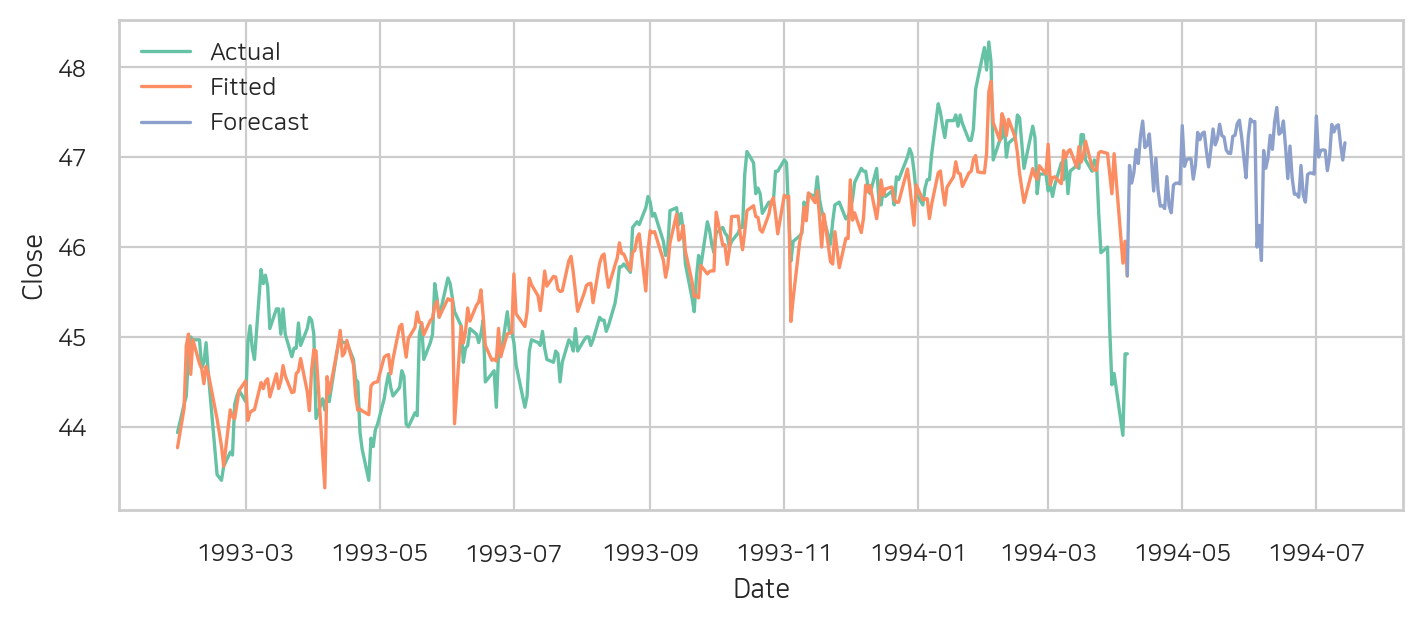

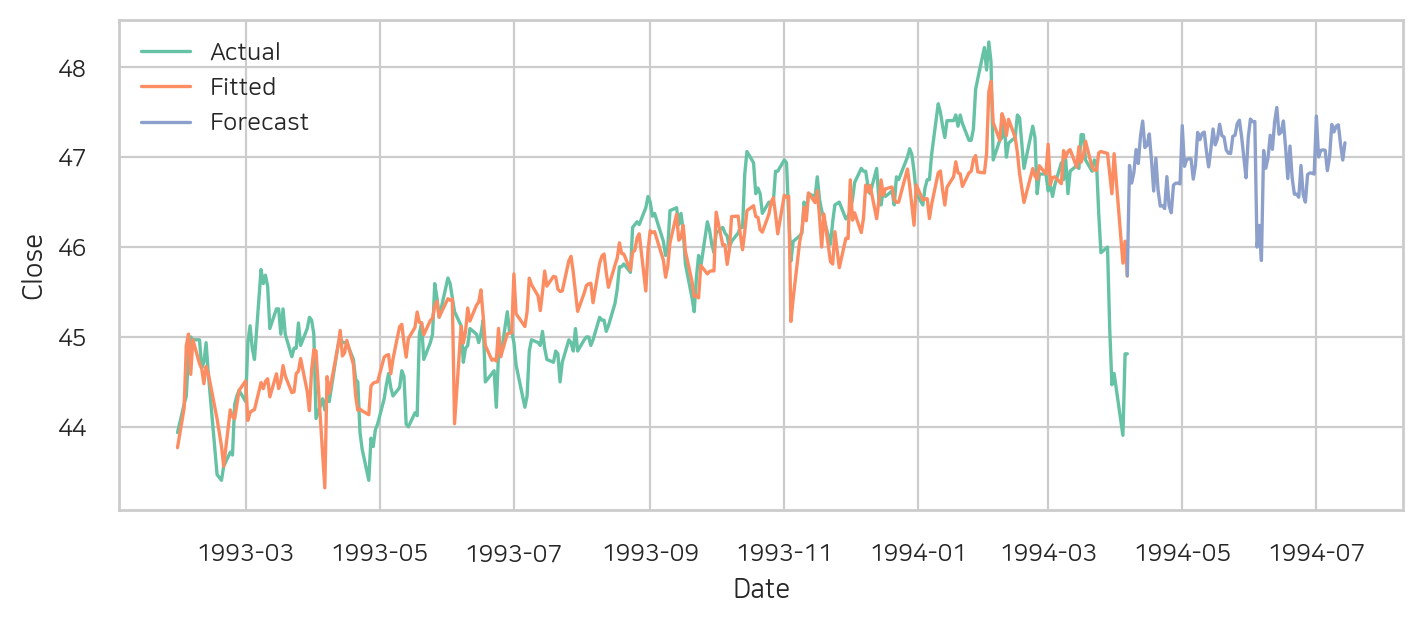

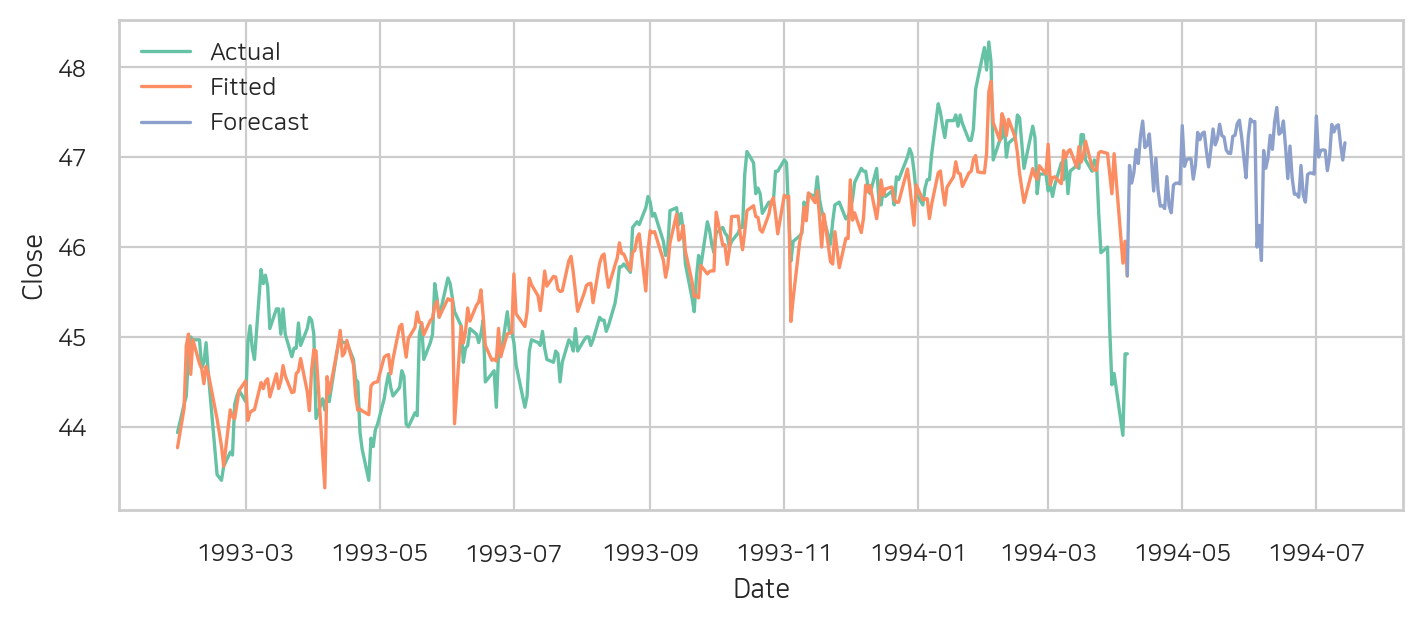

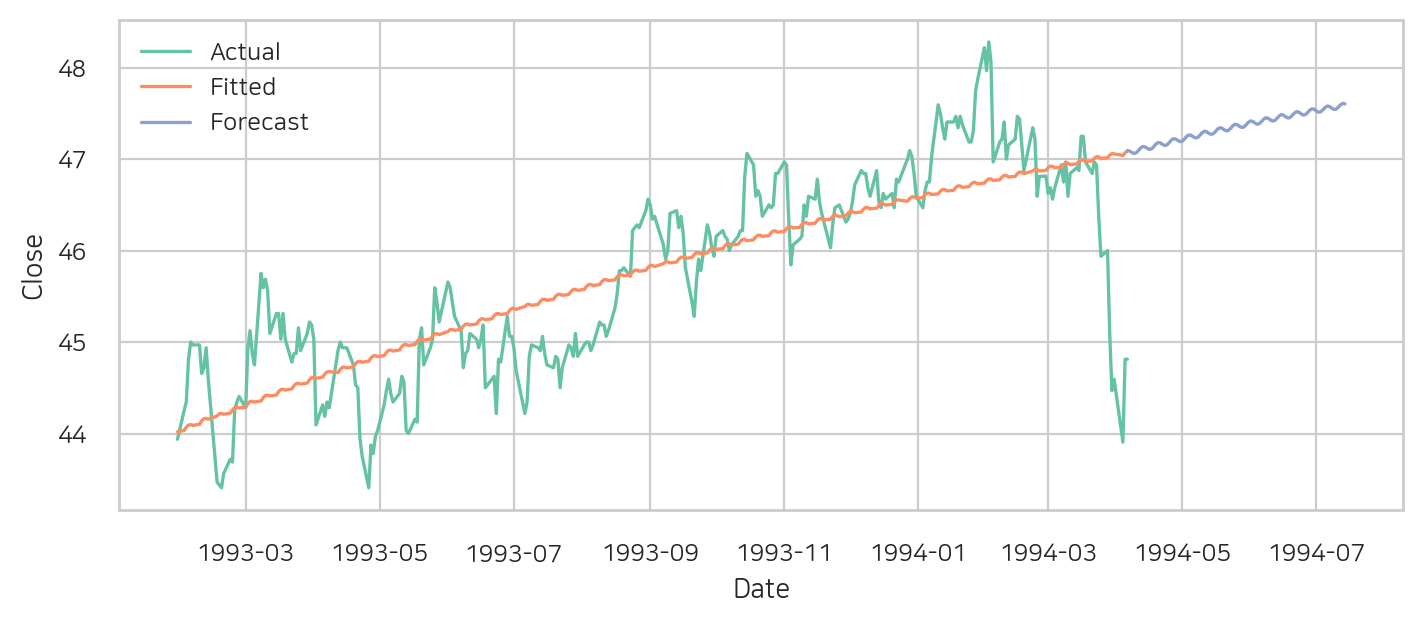

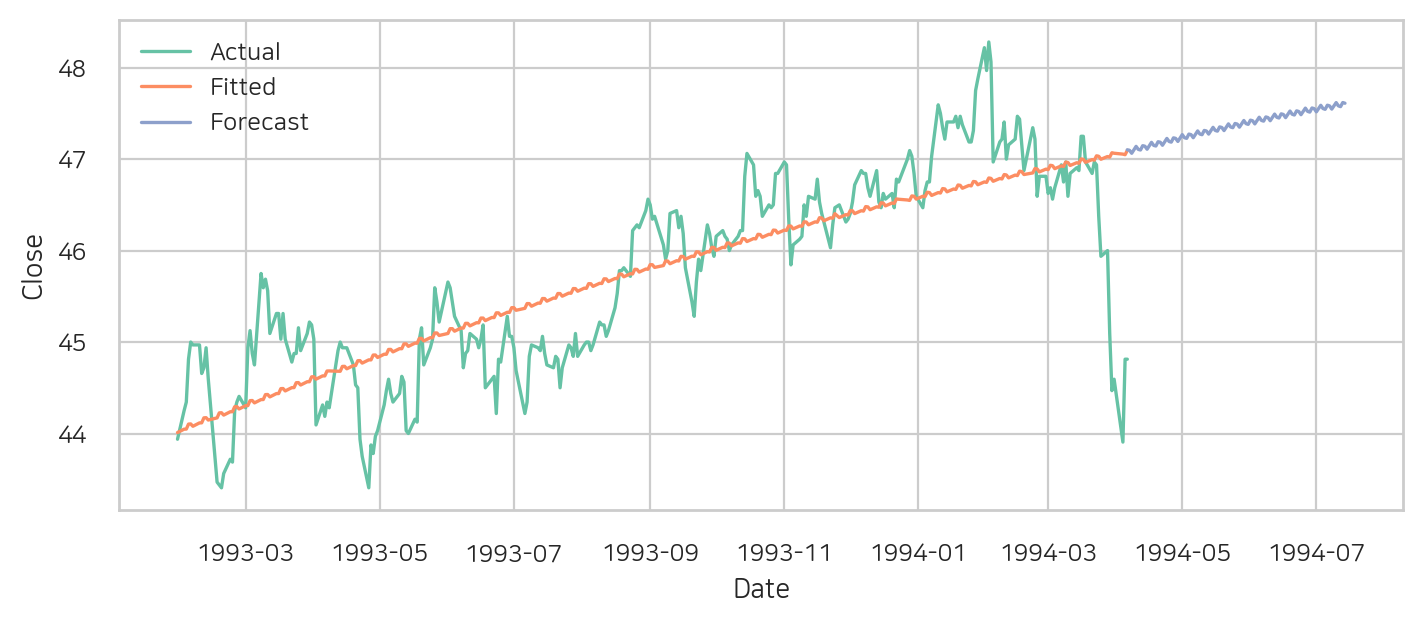

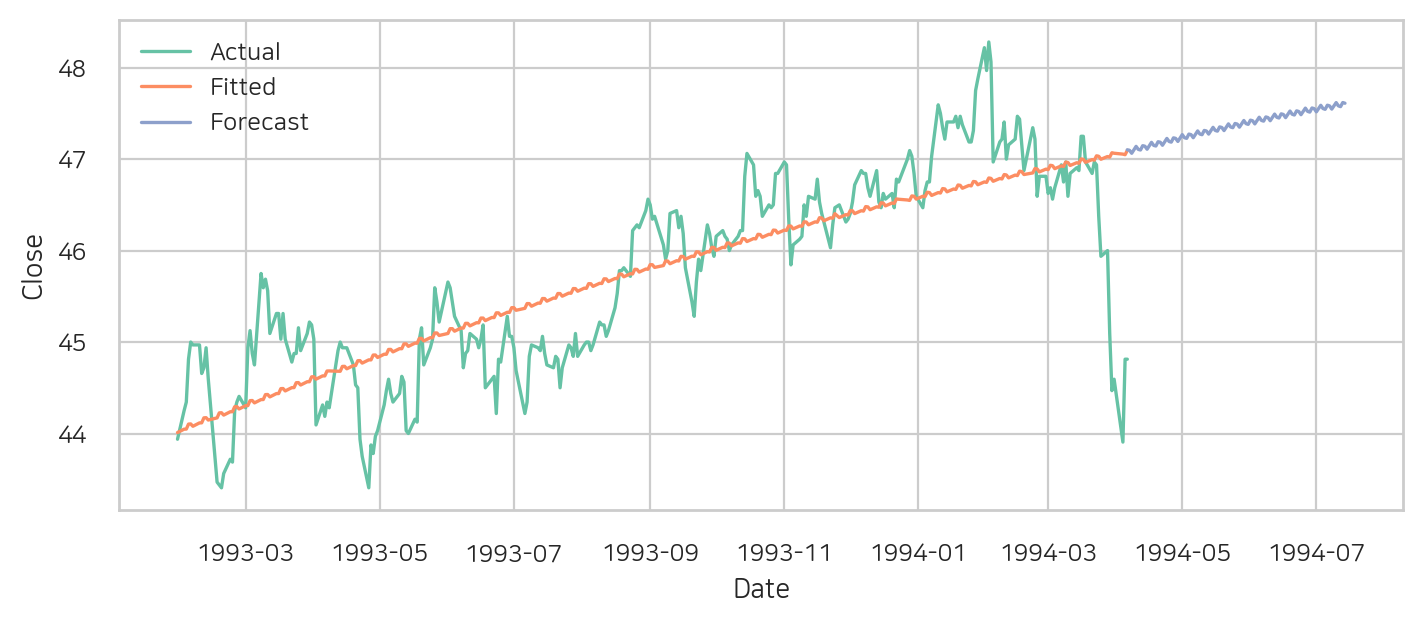

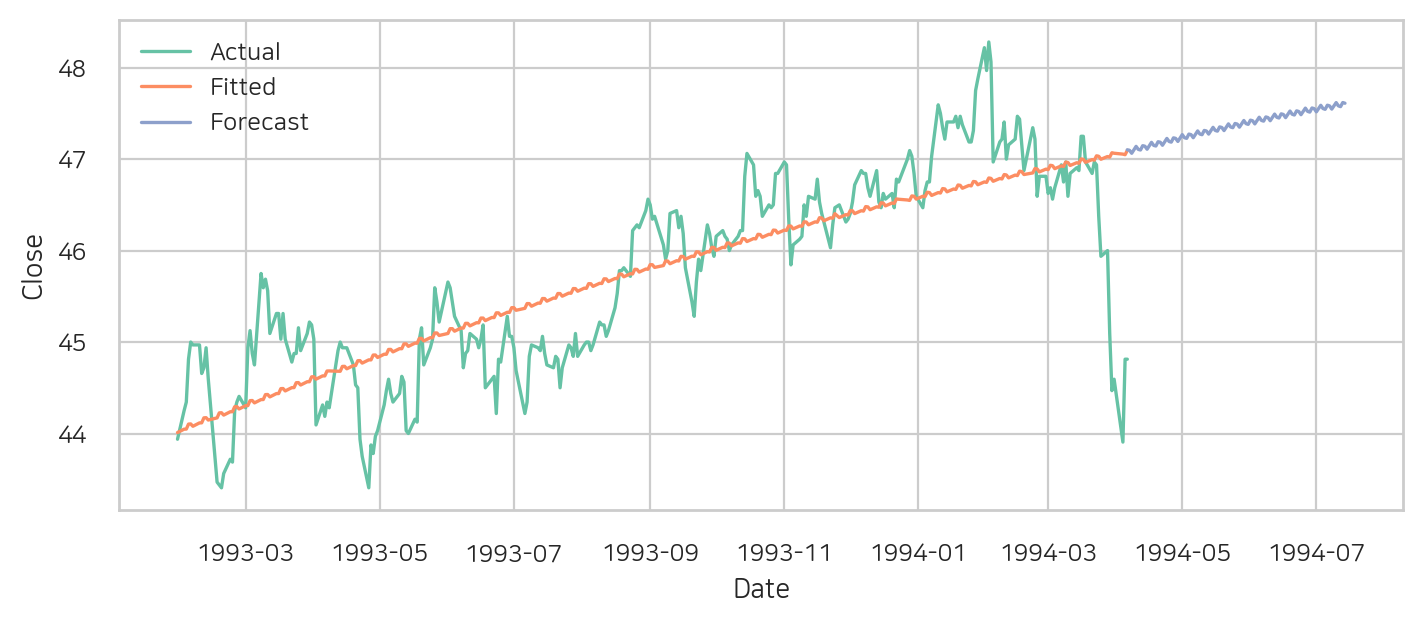

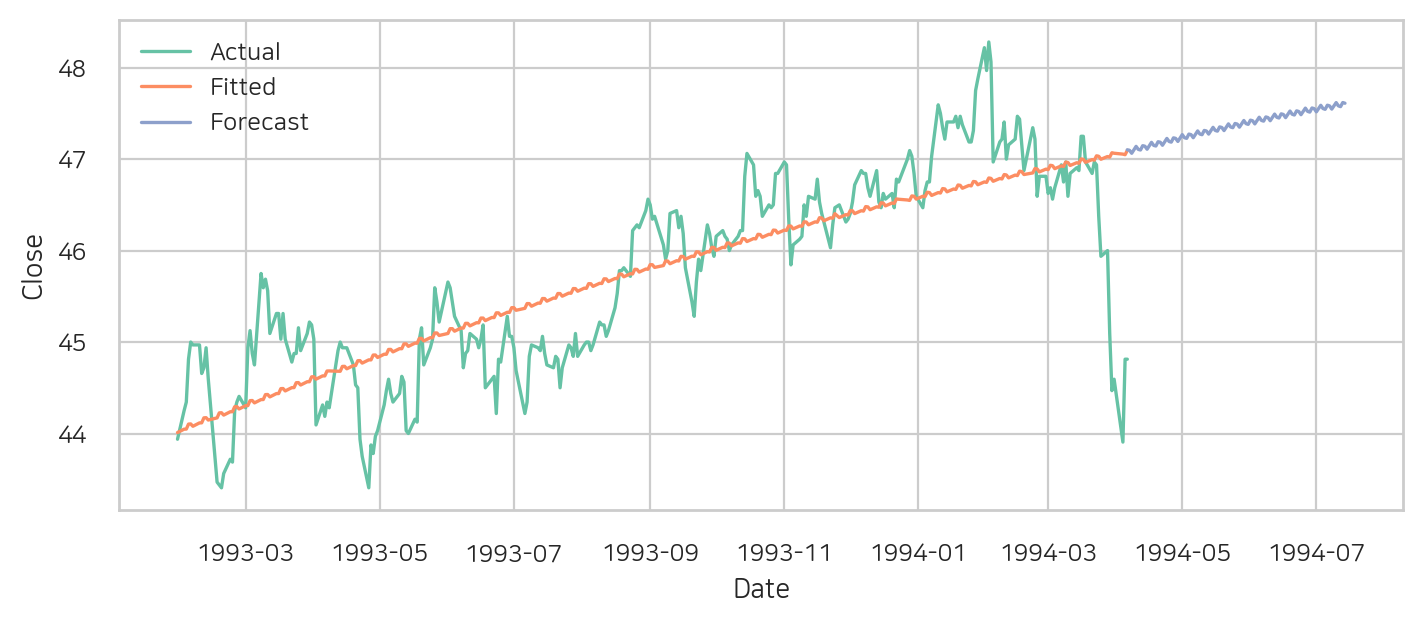

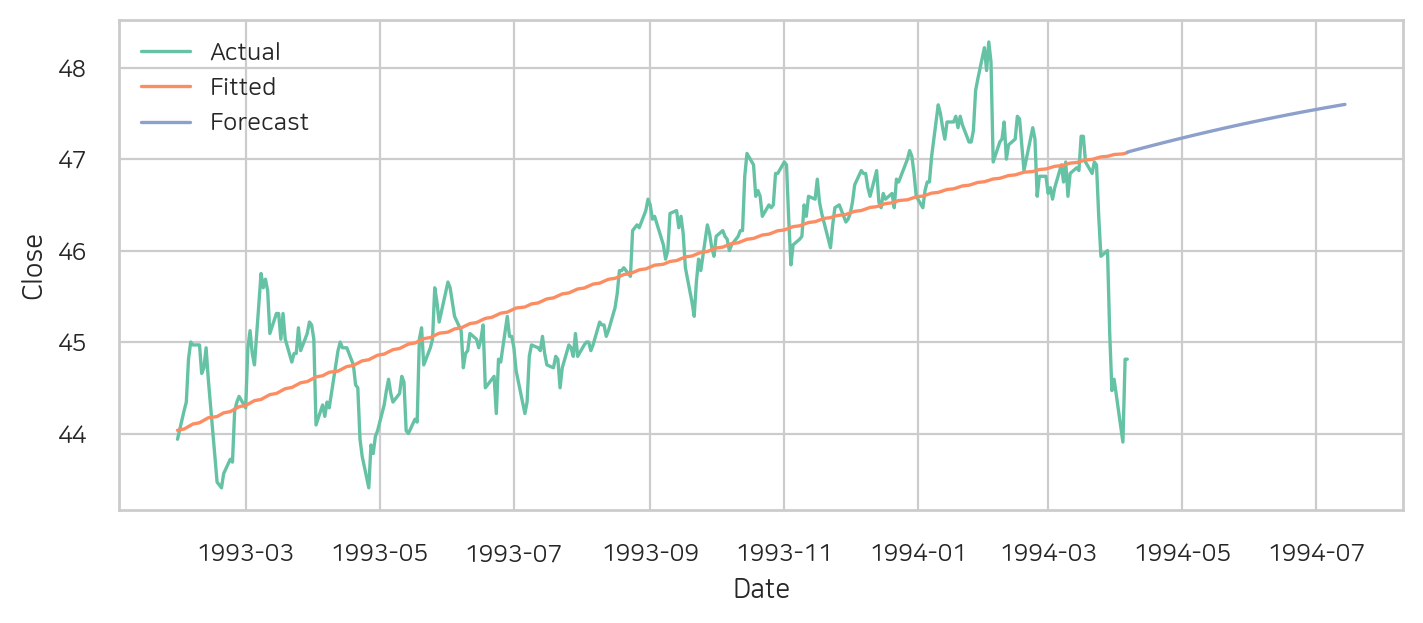

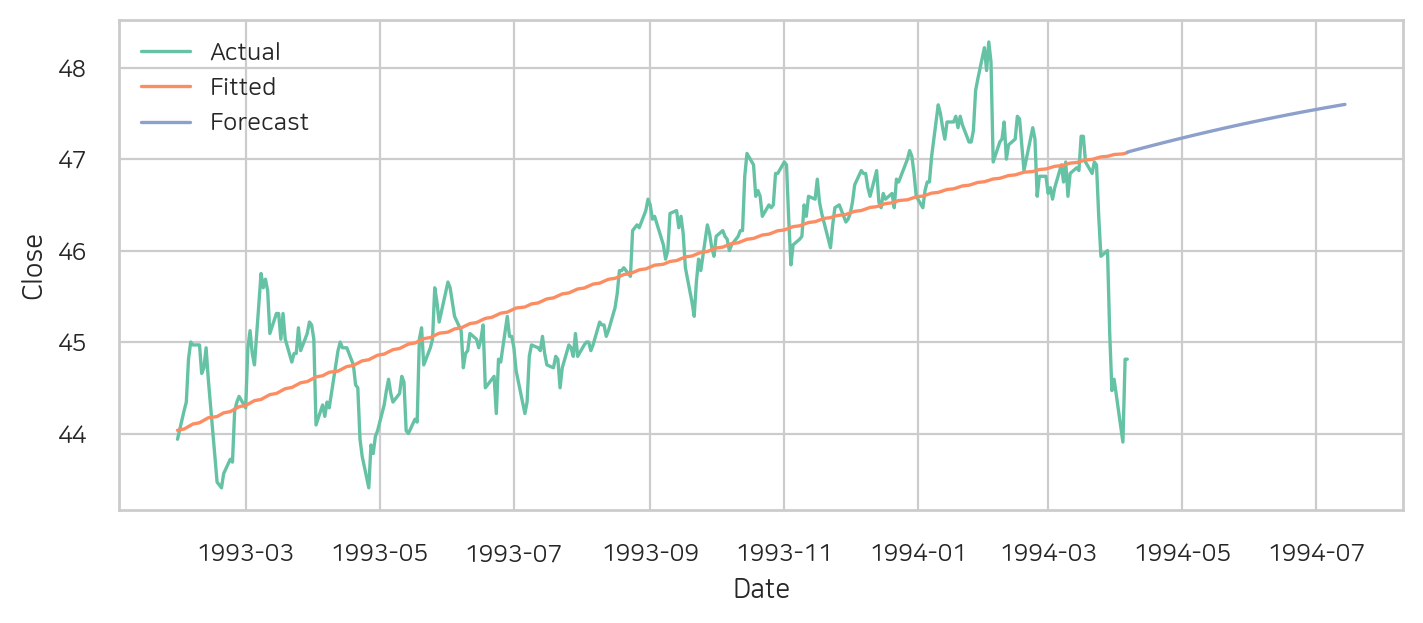

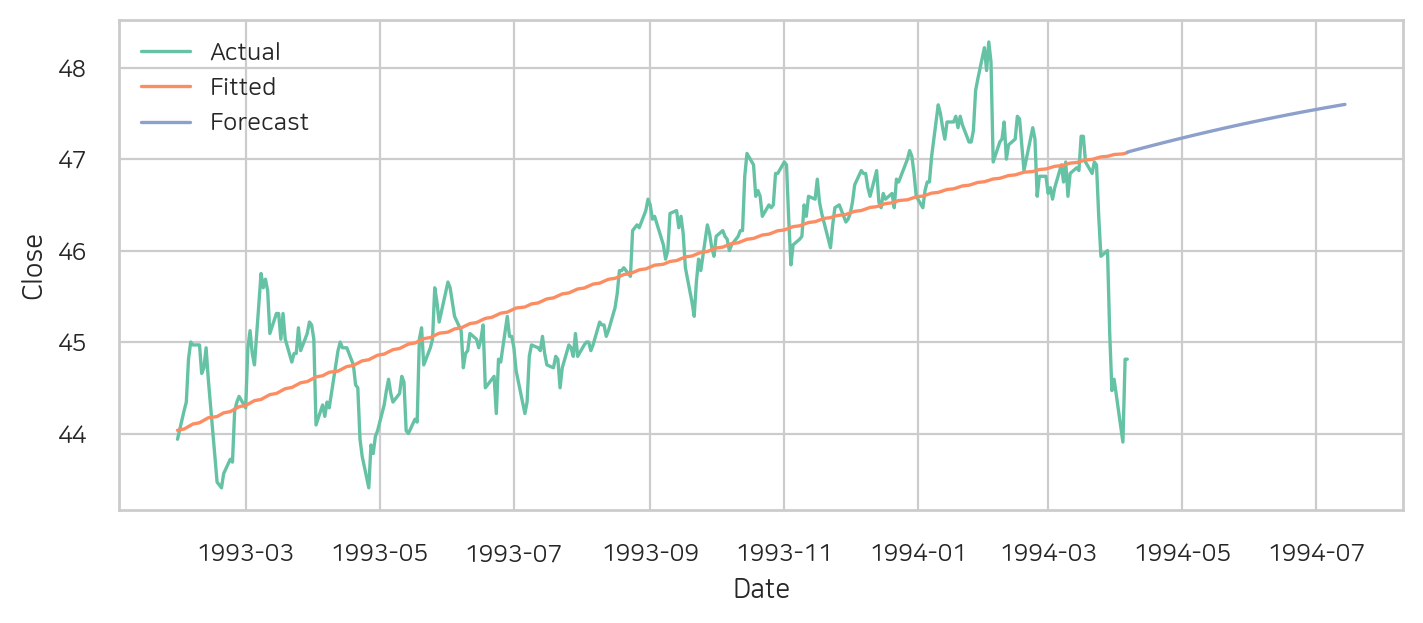

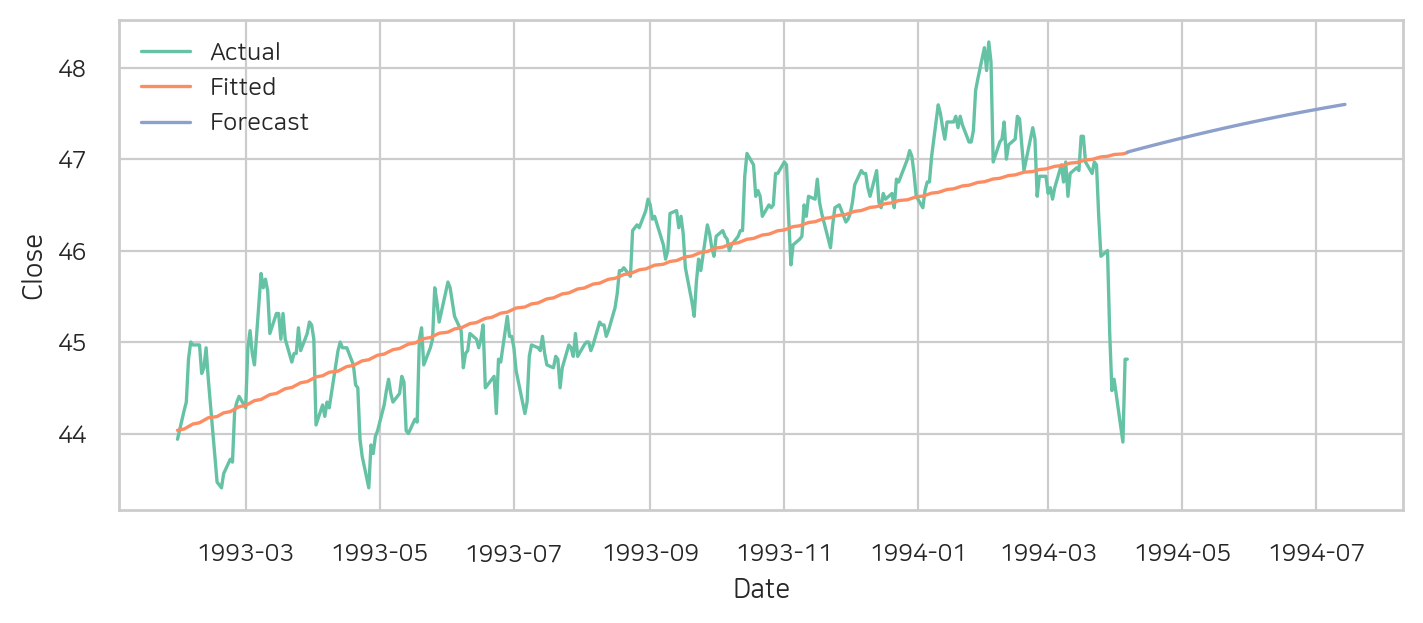

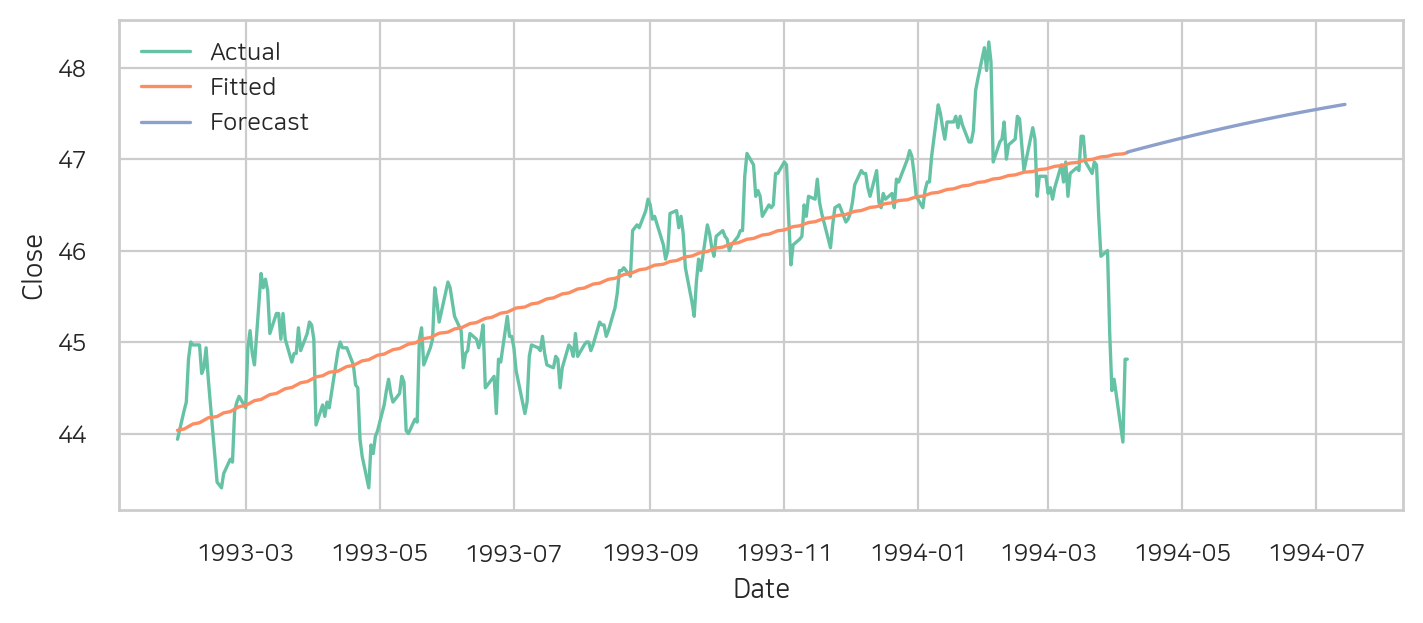

In [53]:
for f in frequencies:
    for o in range(1,100,20):
        # 연간 주기 설정
        fourier = CalendarFourier(freq=f, order=o)

        dp = DeterministicProcess(
            index=snp_500.index,
            constant=True,
            order=2,
            seasonal=False,
            additional_terms=[fourier],
            drop=True,
        )

        X = dp.in_sample()  # 주어진 인덱스에 대해 특징 행렬 생성

        y = snp_500["Close"]

        model = LinearRegression(fit_intercept=False)
        _ = model.fit(X, y)

        y_pred = pd.Series(model.predict(X), index=y.index)

        # 예측
        forecast_index = pd.date_range(start=snp_500.index[-1], periods=100, freq='D')
        X_fore = dp.out_of_sample(steps=100, forecast_index=forecast_index)
        y_fore = pd.Series(model.predict(X_fore), index=forecast_index)

        fig, ax = plt.subplots(figsize=(7, 3))

        # 시각화
        sns.lineplot(data=y, ax=ax, label='Actual')
        sns.lineplot(data=y_pred, ax=ax, label='Fitted')
        sns.lineplot(data=y_fore, ax=ax, label='Forecast')


In [39]:
int(snp_500.index.year.value_counts().median())

252

Text(0.5, 0, 'Hz = 1/일')

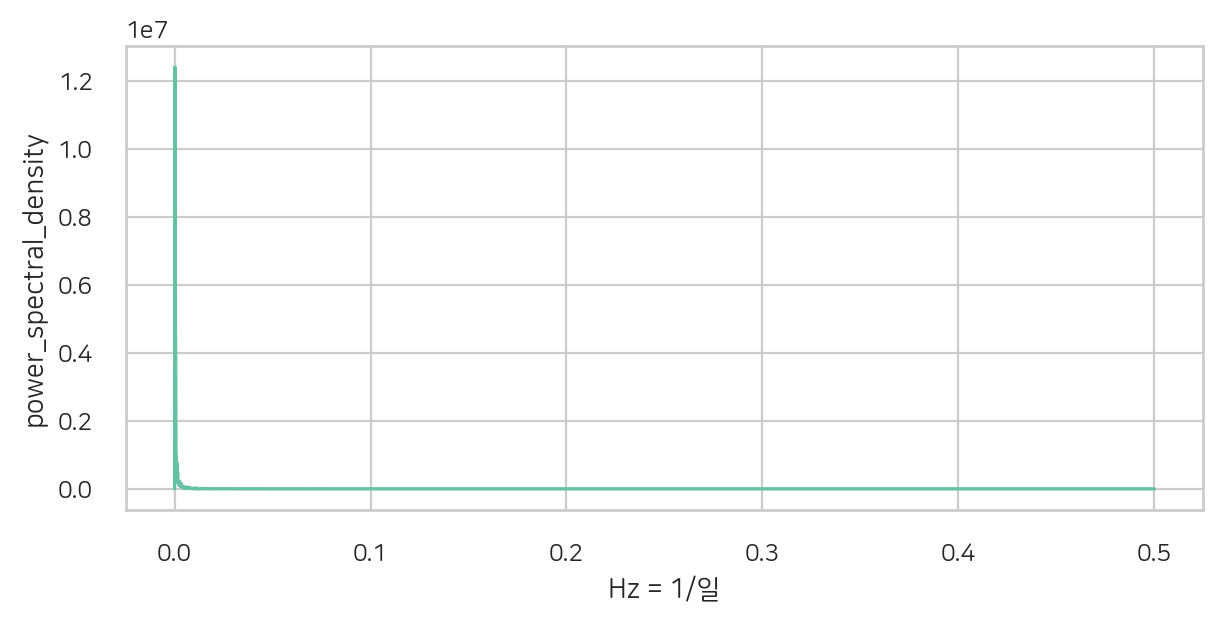

In [40]:
# Periodogram 계산
frequencies, power_spectral_density = signal.periodogram(snp_500["Close"])

fig, ax = plt.subplots(1,1,figsize=(6, 3))
# Periodogram 시각화
sns.lineplot(x=frequencies,
             y=power_spectral_density,ax=ax);

plt.ylabel("power_spectral_density")
plt.xlabel("Hz = 1/일")

### 지수 변화율 분석 및 주기성 시각화

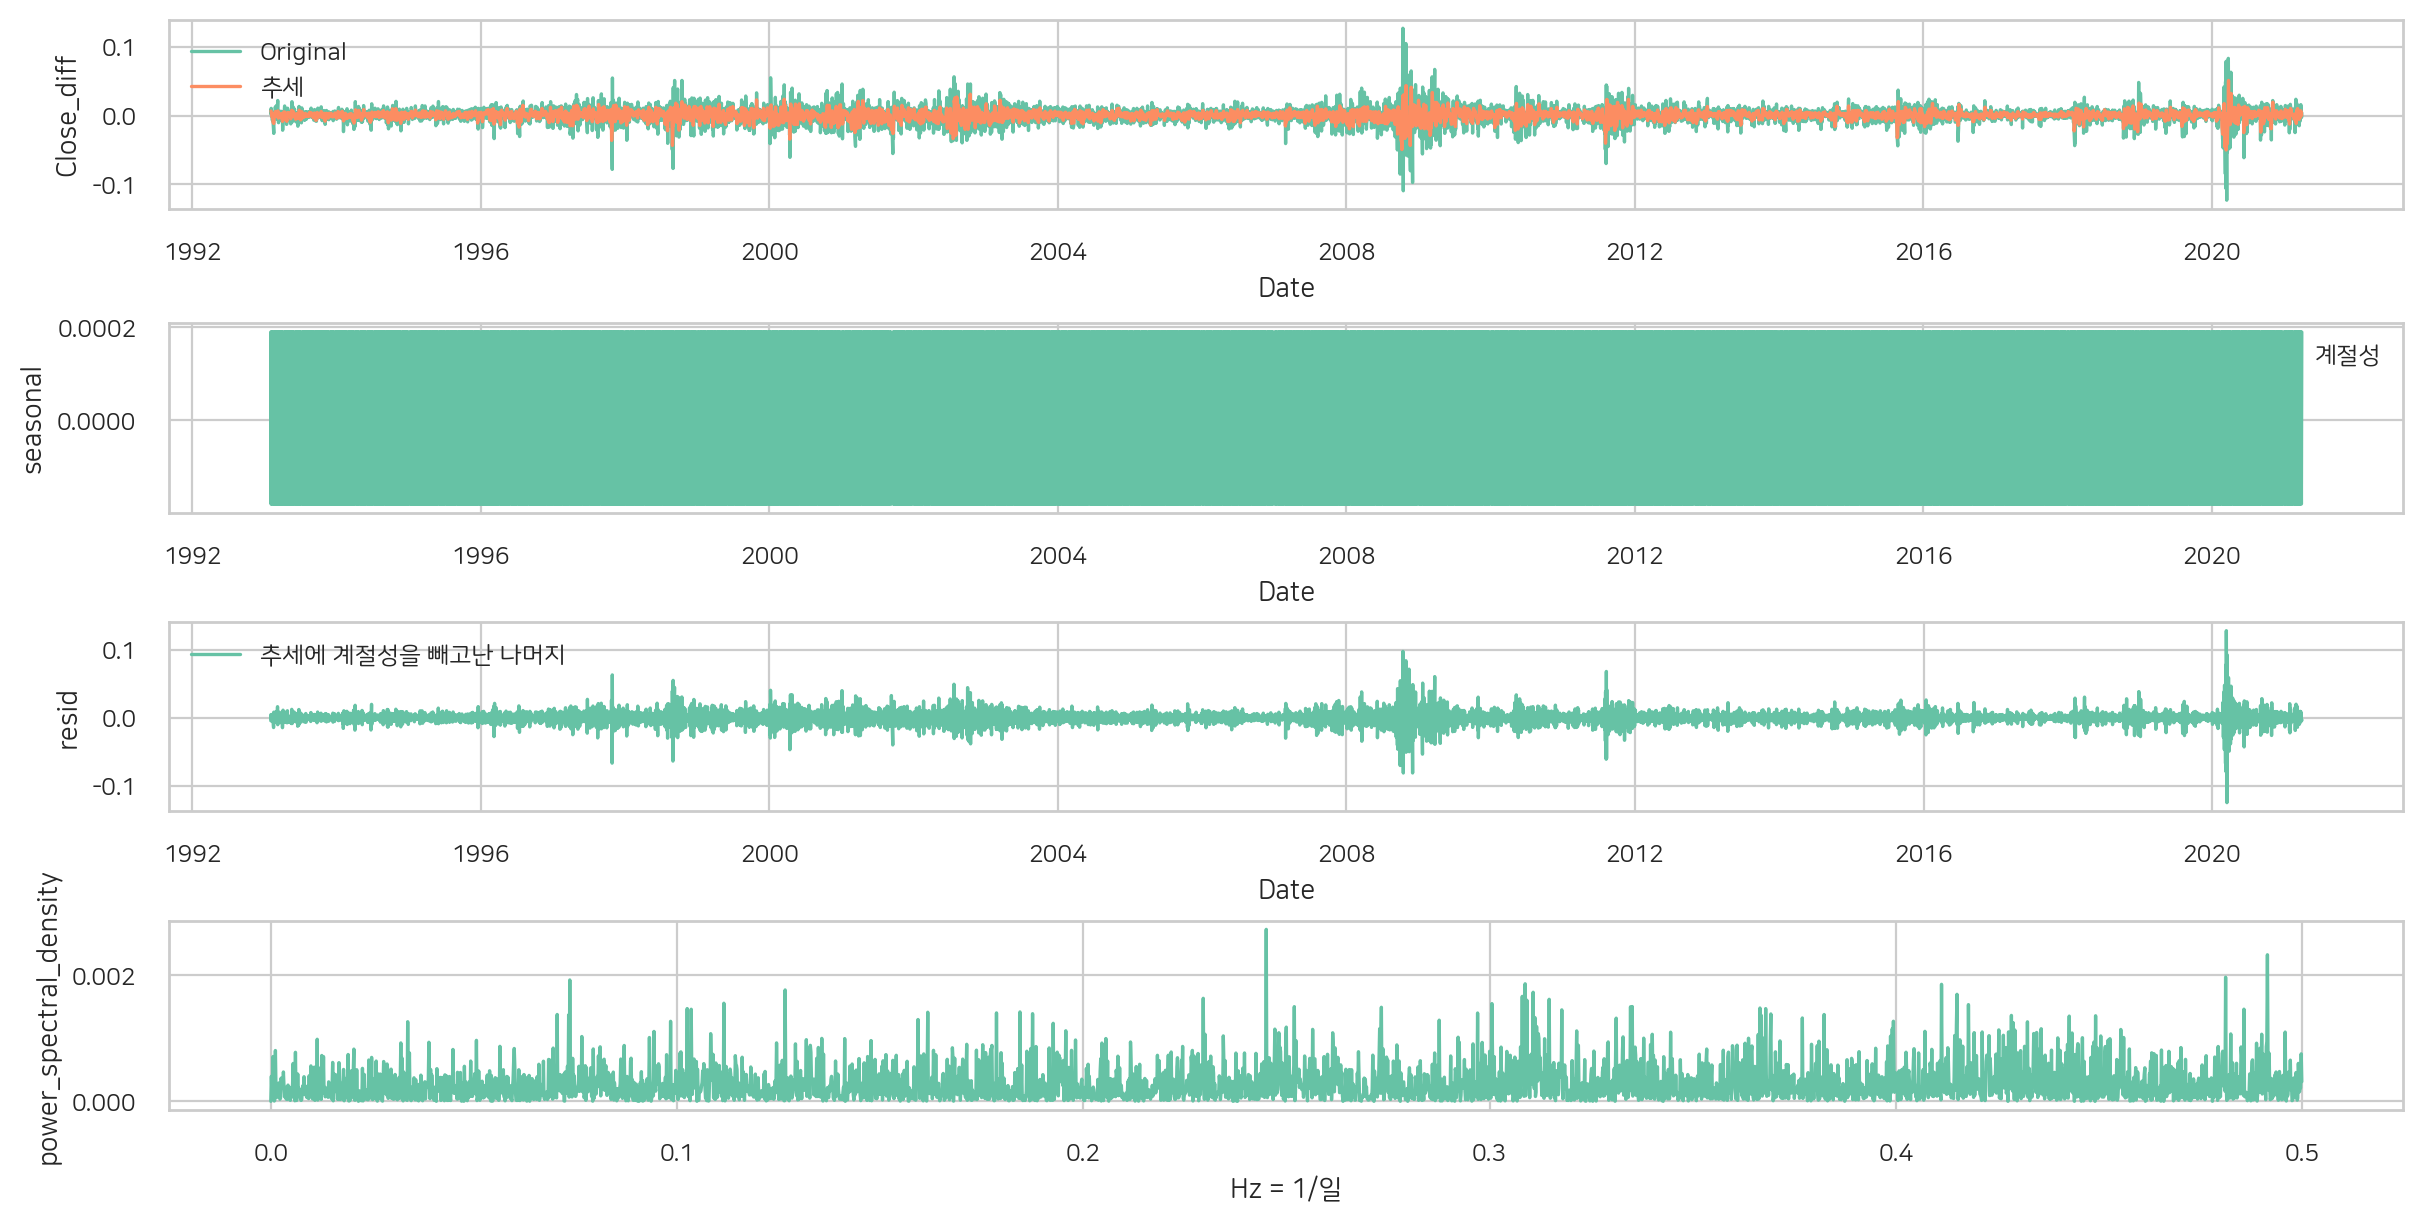

In [41]:
diff_snp = ((snp_500[["Close"]] - snp_500[["Close"]].shift())/snp_500[["Close"]]).dropna()
diff_snp.rename(columns={"Close":"Close_diff"},inplace=True)

# Periodogram 계산
frequencies, power_spectral_density = signal.periodogram(diff_snp["Close_diff"])

max_of_density = power_spectral_density.argmax() # 1

diff_snp_piced = diff_snp["Close_diff"]

# 주기적인 시계열 분해를 통한 주기성 분석
decomposition = seasonal_decompose(diff_snp_piced, period=3)  # 예시로 주별 주기 설정

# 시계열 분해 결과 시각화
fig, ax = plt.subplots(4,1,figsize=(12, 6))

sns.lineplot(diff_snp_piced,label='Original',ax=ax[0])
sns.lineplot(decomposition.trend,label='추세',ax=ax[0])
sns.lineplot(decomposition.seasonal,label='계절성',ax=ax[1])
sns.lineplot(decomposition.resid,label='추세에 계절성을 빼고난 나머지',ax=ax[2])

# Periodogram 계산
frequencies, power_spectral_density = signal.periodogram(diff_snp_piced)

# Periodogram 시각화
sns.lineplot(x=frequencies,
             y=power_spectral_density,ax=ax[3])

plt.ylabel("power_spectral_density")
plt.xlabel("Hz = 1/일");

In [42]:
# 최대 스펙트럼 밀도를 가진 주파수의 위치
max_of_density = power_spectral_density.argmax() # 1

# 최대 스펙트럼 밀도를 가진 주파수의 위치 에 대한 스펙트럼 밀도(주파수의 역수)
1 / frequencies[max_of_density]

4.081127733026467

### 계절성 플롯(seasonal_plot)과 주기도(Periodogram)

In [43]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        errorbar=('ci', False),
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

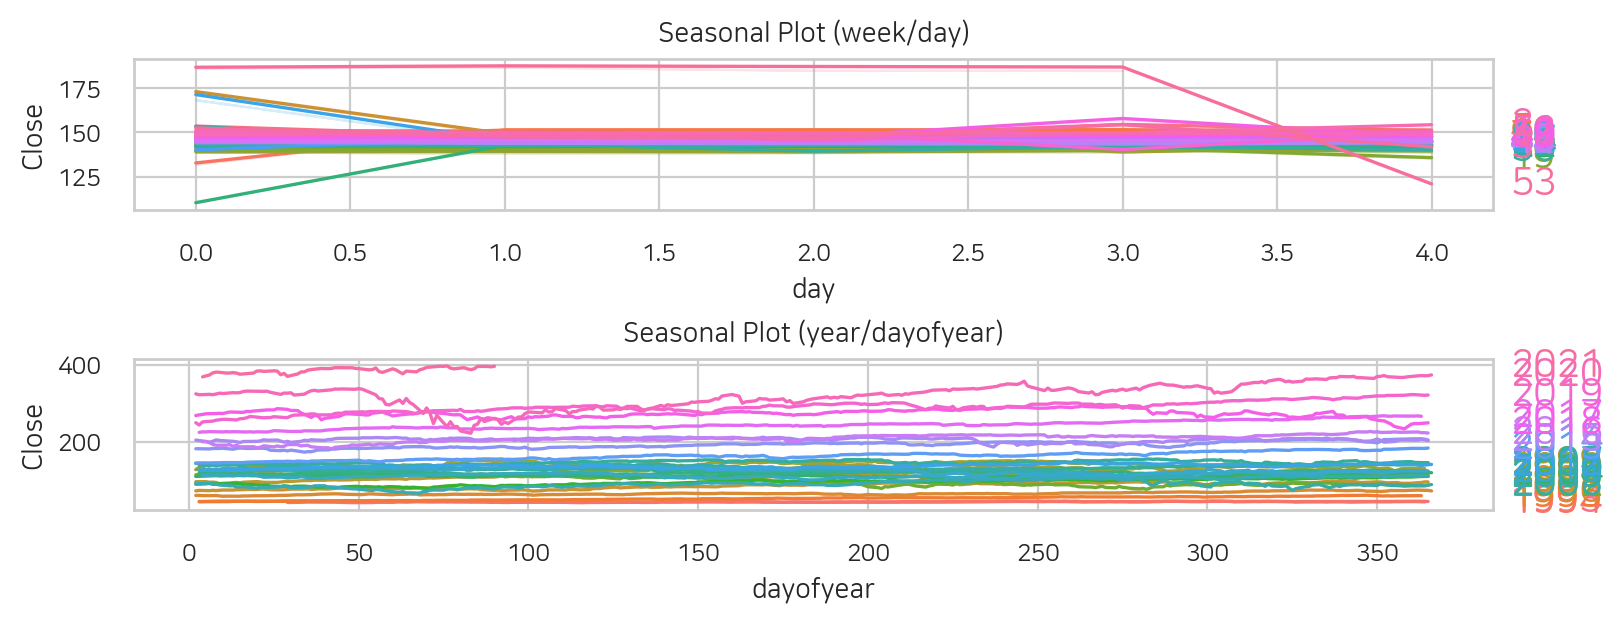

In [44]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(8, 3))


snp_500["day"] = snp_500.index.dayofweek  # The x-axis frequency for weekly seasonality
snp_500["week"] = snp_500.index.isocalendar().week  # The seasonal period for week
snp_500["dayofyear"] = snp_500.index.dayofyear  # The x-axis frequency for yearly seasonality
snp_500["year"] = snp_500.index.year  # The year

seasonal_plot(snp_500, y="Close", period="week", freq="day", ax=ax0)
seasonal_plot(snp_500, y="Close", period="year", freq="dayofyear", ax=ax1);

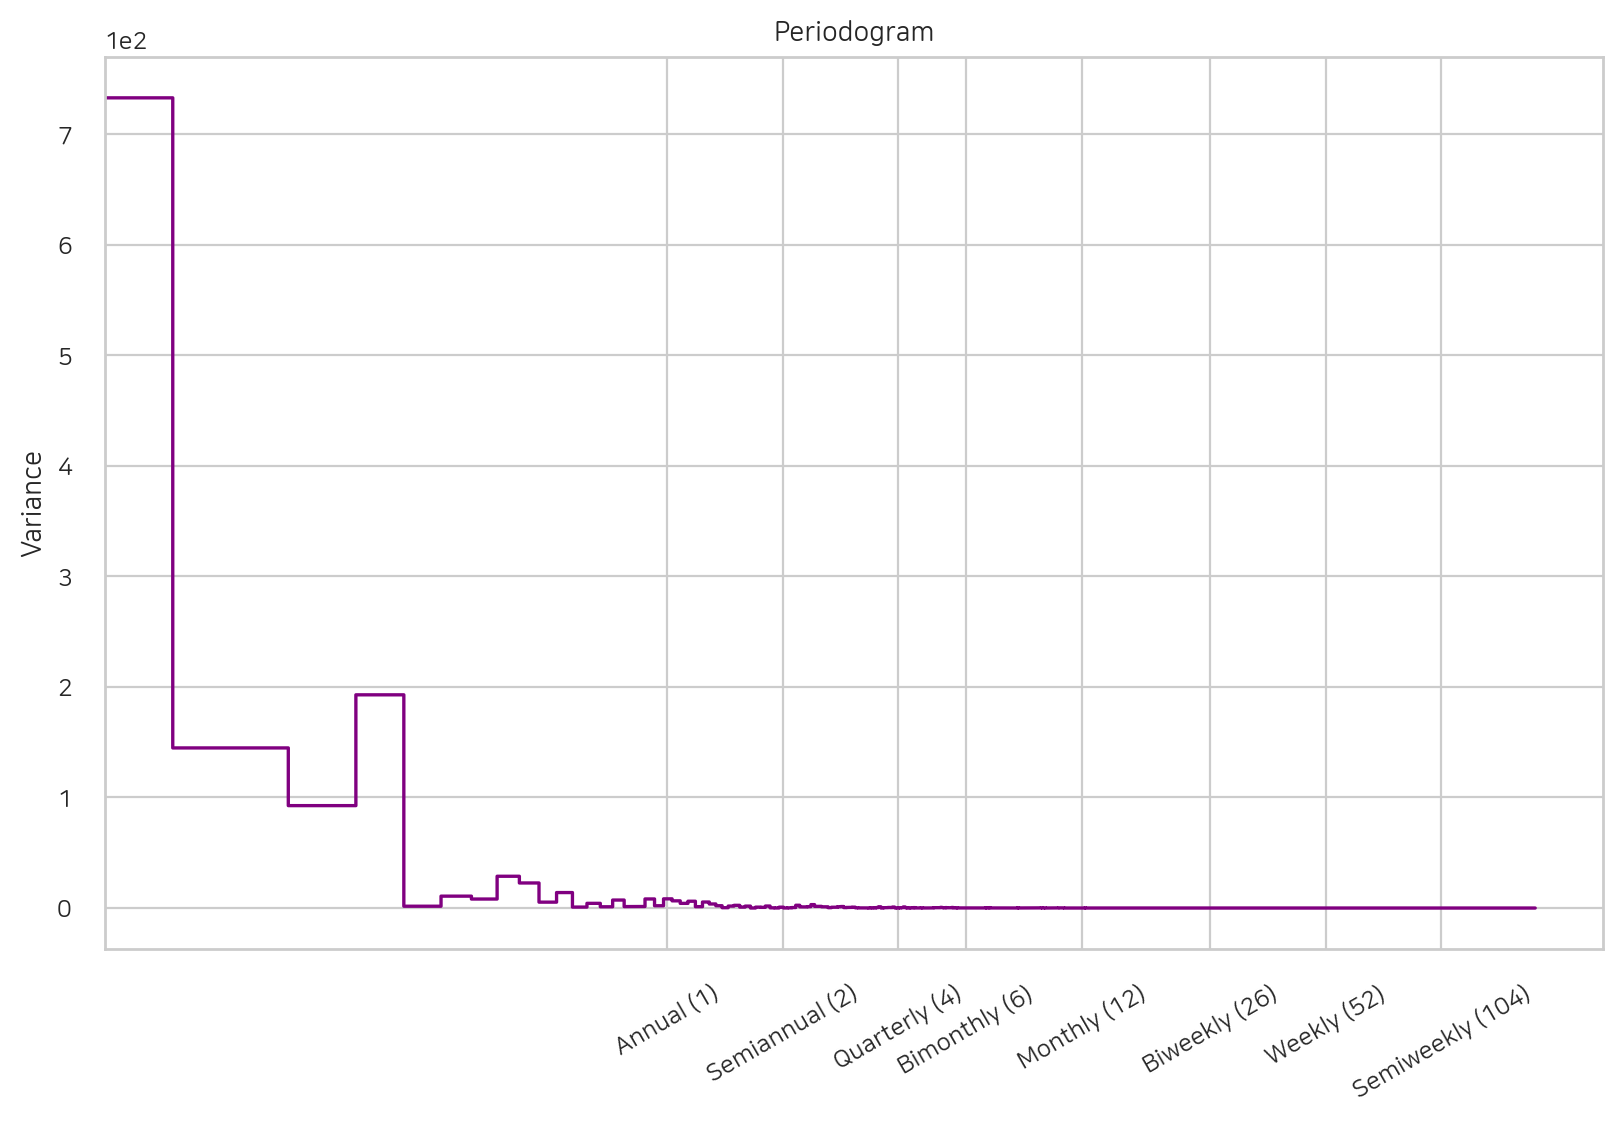

In [45]:
plot_periodogram(snp_500["Close"]);

### `scipy.signal.periodogram`

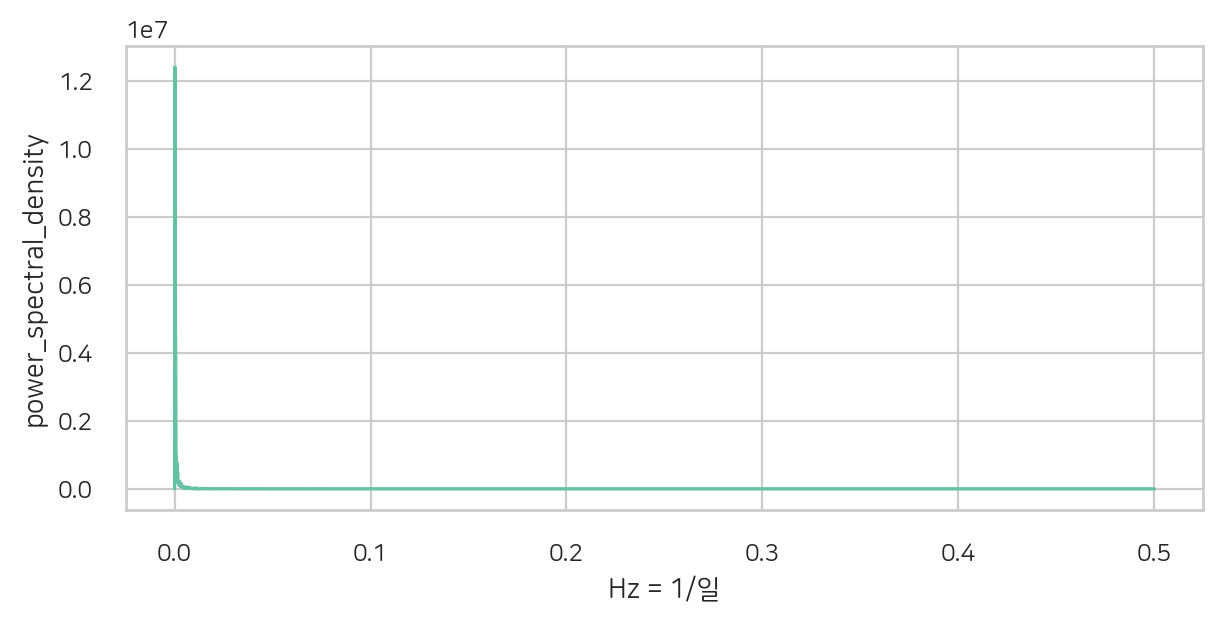

In [46]:
# Periodogram 계산
frequencies, power_spectral_density = signal.periodogram(snp_500["Close"])

fig, ax = plt.subplots(1,1,figsize=(6, 3))
# Periodogram 시각화
sns.lineplot(x=frequencies,
             y=power_spectral_density,ax=ax);

plt.ylabel("power_spectral_density")
plt.xlabel("Hz = 1/일");

In [47]:
max_of_density = power_spectral_density.argmax() # 1
1 / frequencies[max_of_density]

7094.0

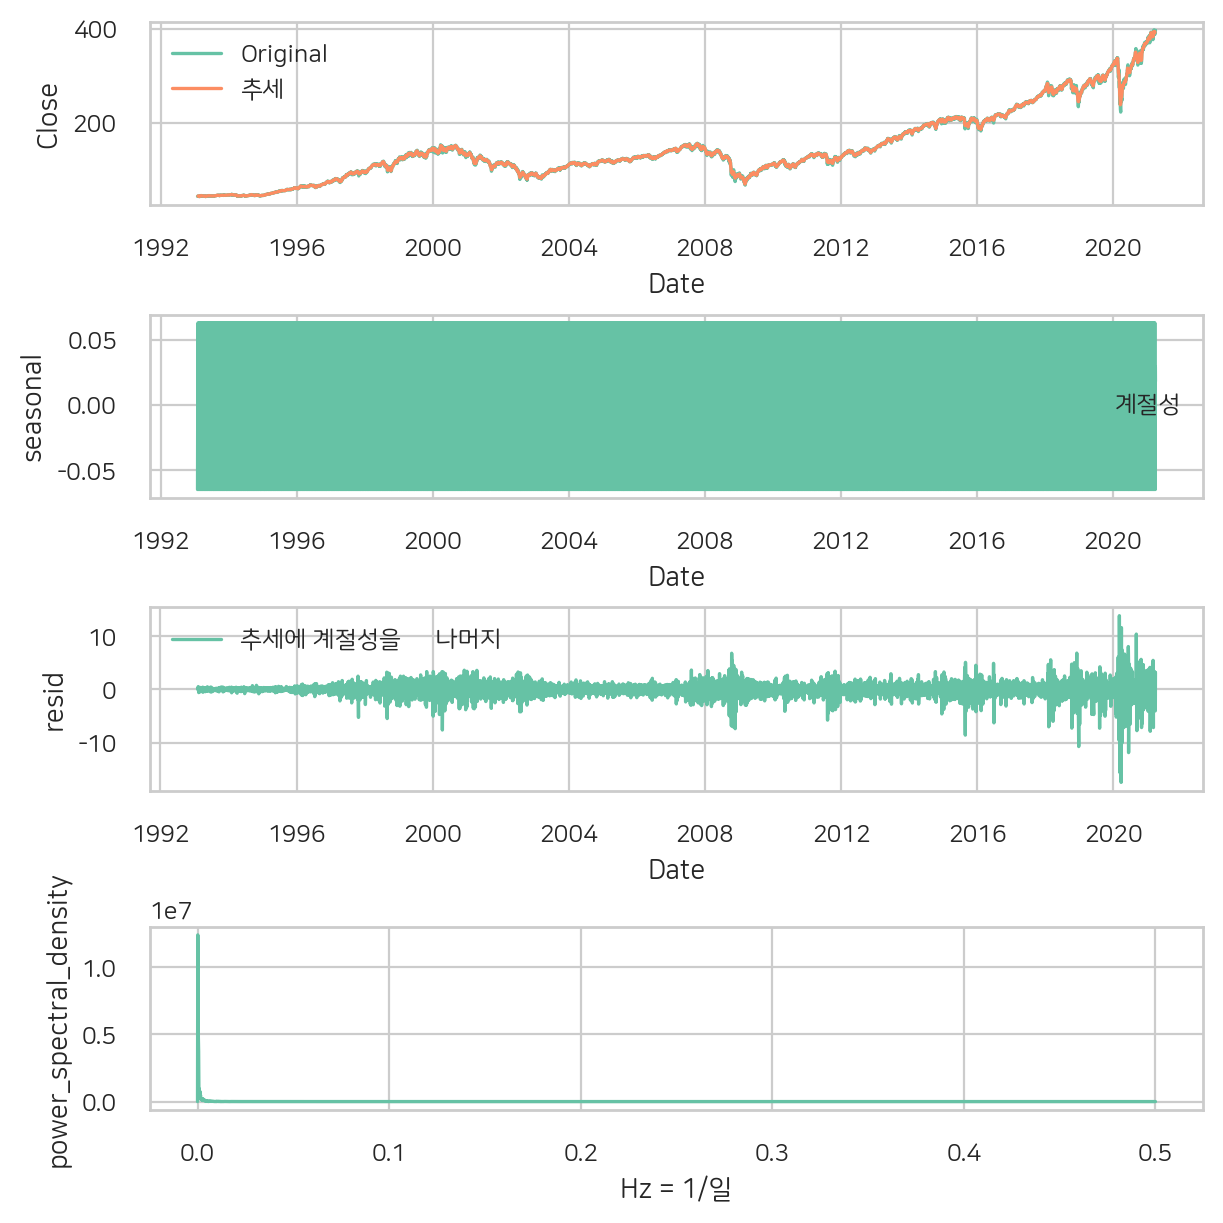

In [48]:
# 주기적인 시계열 분해를 통한 주기성 분석
decomposition = seasonal_decompose(snp_500["Close"], period=7)  # 예시로 주별 주기 설정

# 시계열 분해 결과 시각화
fig, ax = plt.subplots(4,1,figsize=(6, 6))

sns.lineplot(snp_500["Close"],label='Original',ax=ax[0])
sns.lineplot(decomposition.trend,label='추세',ax=ax[0])
sns.lineplot(decomposition.seasonal,label='계절성',ax=ax[1])
sns.lineplot(decomposition.resid,label='추세에 계절성을 뺸 나머지',ax=ax[2])

# Periodogram 계산
frequencies, power_spectral_density = signal.periodogram(snp_500["Close"])

# Periodogram 시각화
sns.lineplot(x=frequencies,
             y=power_spectral_density,ax=ax[3]);

plt.ylabel("power_spectral_density")
plt.xlabel("Hz = 1/일");

### 주가 예측모델 (주기학습)
- `statsmodels`와 `sklearn`
- 연간 및 주간 계절성이 포함된 선형 회귀 모델을 생성.
- **Fourier 변환**: 연간 계절성을 모델링하기 위해 10개의 사인/코사인 쌍을 사용합니다.
- **DeterministicProcess**: 시간에 따른 선형 추세와 계절성(주간 및 연간)을 포함하도록 `DeterministicProcess`를 설정합니다. 
   - `constant`: 상수 항 포함 여부
   - `order`: 데이터의 선형 추세 정도
   - `seasonal`: 주간 계절성을 포함할지 여부
   - `drop`: 다중 공선성을 줄이기 위해 항목 자동 제거
- **모델 학습**: 종속 변수 `y`(S&P 500 종가)와 독립 변수 `X`(생성된 특징들)를 사용하여 선형 회귀 모델학습.
- **예측**: 모델을 사용하여 향후 90일 동안의 예측을 수행하고, 이를 시각화합니다. 

In [49]:
snp_500 = snp_500.head(300)

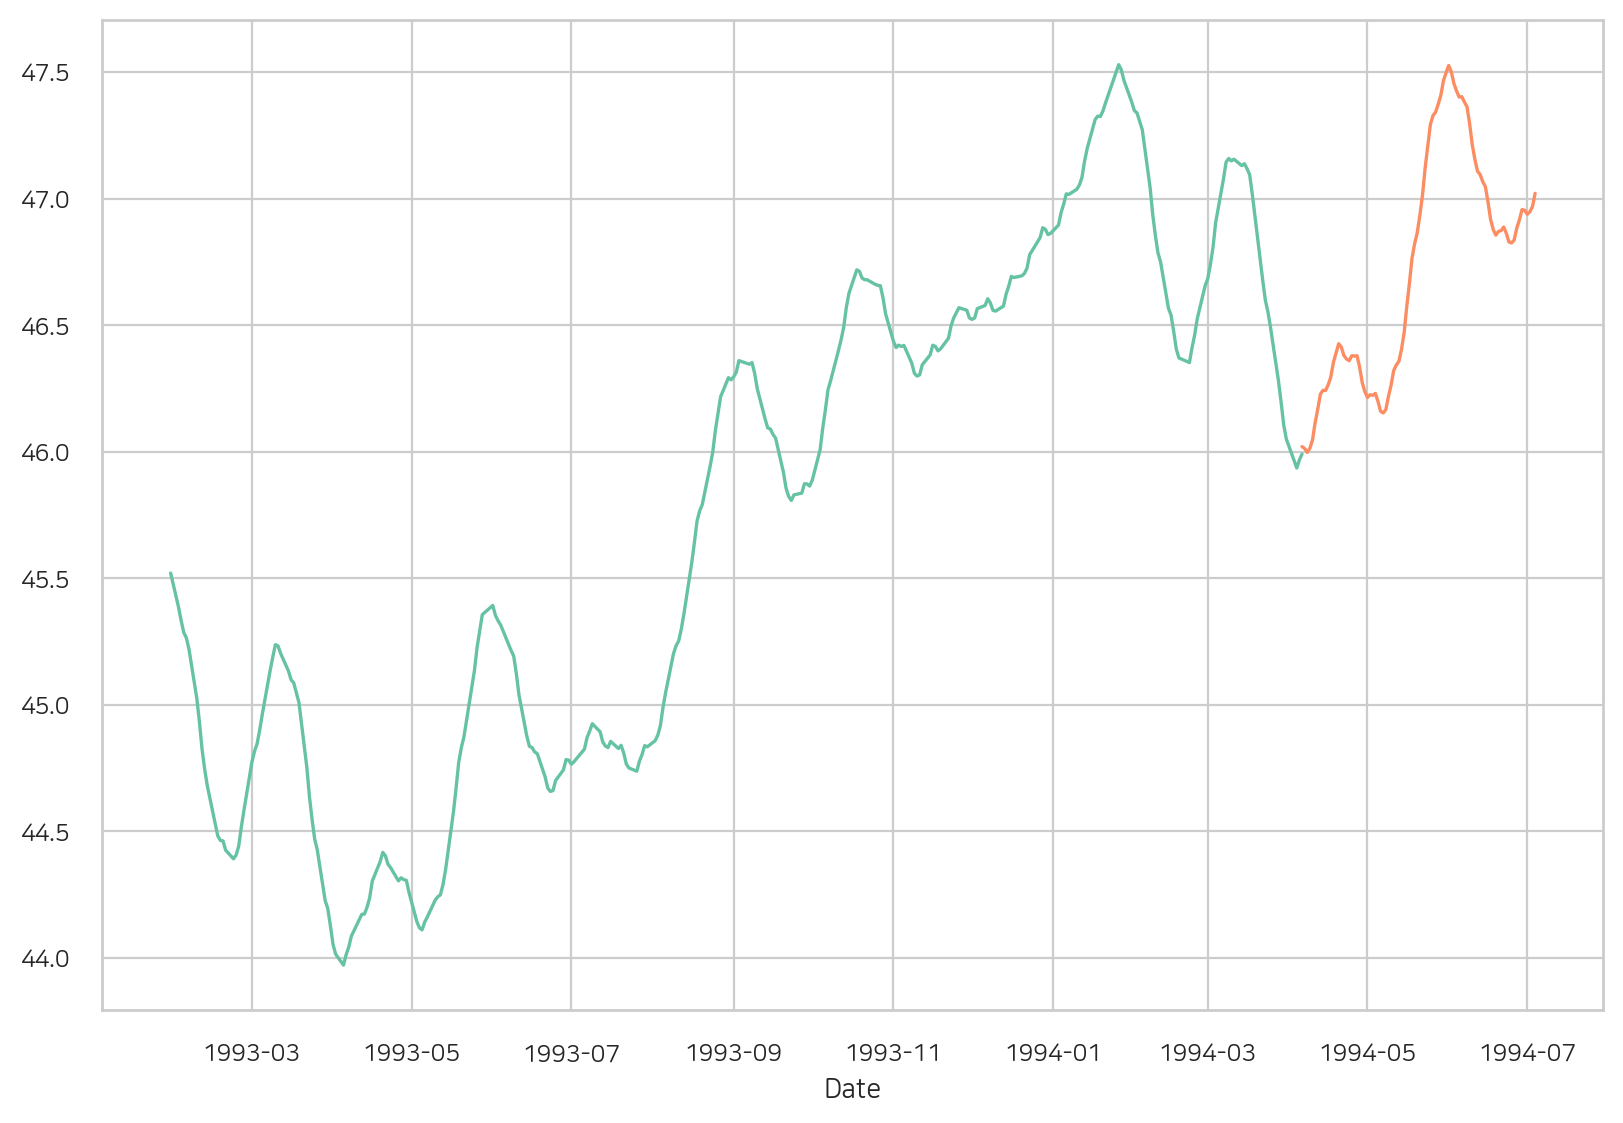

In [50]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.linear_model import LinearRegression
import pandas as pd

""" freq
Y 연간
Q 분기별
M 월별
W 주간
D 일간
H 시간당

order 몇개의 주파수의 조합으로 이루어 지게 할지
"""

fourier = CalendarFourier(freq="YE", order=10)  # 10 sin/cos pairs for "YE"nnual seasonality

dp = DeterministicProcess(
    index=snp_500.index,
    constant=True,  # dummy feature for bias (y-intercept)
    order=1,    # trend 를 포함 할지 _즉 데이터가 시간에따라 선형적으로 변한다면 1
    seasonal=True,  # 주간 계절성
    period=7,  # 주간 계절성
    additional_terms=[fourier], # 연간 계절성을 추가로 포함 (위에 정의한 fourier)
    drop=True,  # 다중 공선성(collinearity)을 일으킬 수 있는 항목들을 자동으로 제거합니다.
)

X = dp.in_sample()  # create features for dates in index

y = snp_500["Close"]

model = LinearRegression(fit_intercept=False)
_ = model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=y.index)


# Forecasting
forecast_index = pd.date_range(start=snp_500.index[-1], periods=90, freq='D')
X_fore = dp.out_of_sample(steps=90, forecast_index=forecast_index)
y_fore = pd.Series(model.predict(X_fore), index=forecast_index)

fig, ax = plt.subplots()

# Plotting
# sns.lineplot(y,ax=ax)
sns.lineplot(y_pred,ax=ax)
sns.lineplot(y_fore,ax=ax);